In [11]:
import snapatac2 as snap
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import scanpy as sc
import snapatac2 as snap
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import scanpy as sc
# import pyranges as pr
import scipy.sparse as sp
from scipy import sparse
from scipy.io import mmwrite
from importlib.metadata import version
# from pygenometracks.tracksClass import PlotTracks
import warnings
warnings.filterwarnings('ignore')

from __future__ import annotations
from typing_extensions import Literal

import numpy as np
from scipy.stats import chi2, norm, zscore
import logging

from snapatac2._snapatac2 import AnnData, AnnDataSet
from snapatac2.tools._misc import aggregate_X

def marker_regions(
    data: AnnData | AnnDataSet,
    groupby: str | list[str],
    pvalue: float = 0.01,
) -> dict[str, list[str]]:
    """
    A quick-and-dirty way to get marker regions.

    Parameters
    ----------
    data
        AnnData or AnnDataSet object.
    groupby
        Grouping variable.
    pvalue
        P-value threshold.
    """
    count = aggregate_X(data, groupby, normalize="RPKM")
    z = zscore(np.log2(1 + count.X), axis = 0)
    peaks = {}
    for i in range(z.shape[0]):
        select = norm.sf(z[i, :]) < pvalue
        if np.where(select)[0].size >= 1:
            peaks[count.obs_names[i]] = count.var_names[select]
    return peaks

def mad(data, axis=None):
    """ Compute Median Absolute Deviation """
    return np.median(np.absolute(data - np.median(data, axis)), axis)

def modified_zscore(matrix, axis=0):
    """ Compute Modified Z-score for a matrix along specified axis """
    median = np.median(matrix, axis=axis)
    median_absolute_deviation = mad(matrix, axis=axis)
    min_non_zero = np.min(median_absolute_deviation[median_absolute_deviation > 0])
    median_absolute_deviation[median_absolute_deviation == 0] = min_non_zero

    if axis == 0:
        modified_z_scores = 0.6745 * (matrix - median) / median_absolute_deviation
    elif axis == 1:
        modified_z_scores = 0.6745 * (matrix.T - median).T / median_absolute_deviation
    else:
        raise ValueError("Invalid axis, it should be 0 or 1")

    return modified_z_scores

def diff_test(
    data: AnnData | AnnDataSet,
    cell_group1: list[int] | list[str],
    cell_group2: list[int] | list[str],
    features : list[str] | list[int] | None = None,
    covariates: list[str] | None = None,
    direction: Literal["positive", "negative", "both"] = "both",
    min_log_fc: float = 0.25,
    min_pct: float = 0.05,
) -> 'polars.DataFrame':
    """
    Identify differentially accessible regions.

    Parameters
    ----------
    data
        AnnData or AnnDataSet object.
    cell_group1
        cells belonging to group 1. This can be a list of cell barcodes, indices or 
        boolean mask vector.
    cell_group2
        cells belonging to group 2. This can be a list of cell barcodes, indices or 
        boolean mask vector.
    features
        Features/peaks to test. If None, all features are tested.
    covariates
    direction
        "positive", "negative", or "both".
        "positive": return features that are enriched in group 1.
        "negative": return features that are enriched in group 2.
        "both": return features that are enriched in group 1 or group 2.
    min_log_fc
        Limit testing to features which show, on average, at least
        X-fold difference (log2-scale) between the two groups of cells.
    min_pct
        Only test features that are detected in a minimum fraction of min_pct
        cells in either of the two populations. 

    Returns
    -------
    pl.DataFrame
        A DataFrame with 4 columns: "feature name", "log2(fold_change)",
        "p-value", and "adjusted p-value".
    """
    import polars as pl

    def to_indices(xs, type):
        xs = [_convert_to_bool_if_np_bool(x) for x in xs]
        if all(isinstance(x, bool) for x in xs):
            return [i for i, value in enumerate(xs) if value]
        elif all([isinstance(item, str) for item in xs]):
            if type == "obs":
                if data.isbacked:
                    return data.obs_ix(xs)
                else:
                    return [data.obs_names.get_loc(x) for x in xs]
            else:
                if data.isbacked:
                    return data.var_ix(xs)
                else:
                    return [data.var_names.get_loc(x) for x in xs]
        else:
            return xs

    cell_group1 = to_indices(cell_group1, "obs")
    n_group1 = len(cell_group1)
    cell_group2 = to_indices(cell_group2, "obs")
    n_group2 = len(cell_group2)

    cell_by_peak = data.X[cell_group1 + cell_group2, :].tocsc()
    test_var = np.array([0] * n_group1 + [1] * n_group2)
    if covariates is not None:
        raise NameError("covariates is not implemented")

    features = range(data.n_vars) if features is None else to_indices(features, "var")
    logging.info("Input contains {} features, now perform filtering with 'min_log_fc = {}' and 'min_pct = {}' ...".format(len(features), min_log_fc, min_pct))
    filtered = _filter_features(
        cell_by_peak[:n_group1, :],
        cell_by_peak[n_group1:, :],
        features,
        direction,
        min_pct,
        min_log_fc,
    )

    if len(filtered) == 0:
        logging.warning("Zero feature left after filtering, perhaps 'min_log_fc' or 'min_pct' is too large")
        return pl.DataFrame()
    else:
        features, log_fc = zip(*filtered)
        logging.info("Testing {} features ...".format(len(features)))
        pvals = _diff_test_helper(cell_by_peak, test_var, features, covariates)
        var_names = data.var_names
        return pl.DataFrame({
            "feature name": [var_names[i] for i in features],
            "log2(fold_change)": np.array(log_fc),
            "p-value": np.array(pvals),
            "adjusted p-value": _p_adjust_bh(pvals),
        }).sort("adjusted p-value")

def _p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def _filter_features(mat1, mat2, peak_indices, direction,
    min_pct, min_log_fc, pseudo_count = 1,
):
    def rpm(m):
        x = np.ravel(np.sum(m, axis = 0)) + pseudo_count
        s = x.sum()
        return x / (s / 1000000)

    def pass_min_pct(i):
        cond1 = mat1[:, i].count_nonzero() / mat1.shape[0] >= min_pct 
        cond2 = mat2[:, i].count_nonzero() / mat2.shape[0] >= min_pct 
        return cond1 or cond2

    def adjust_sign(fc):
        if direction == "both":
            return abs(fc)
        elif direction == "positive":
            return fc
        elif direction == "negative":
            return -fc
        else:
            raise NameError("direction must be 'positive', 'negative' or 'both'")

    log_fc = np.log2(rpm(mat1) / rpm(mat2))
    peak_indices = [i for i in peak_indices if pass_min_pct(i)]
    return [(i, log_fc[i])  for i in peak_indices if adjust_sign(log_fc[i]) >= min_log_fc]

def _diff_test_helper(mat, z, peaks=None, covariate=None) -> list[float]:
    """
    Parameters
    ----------
    mat
        cell by peak matrix.
    z
        variables to test
    peaks
        peak indices
    covariate 
        additional variables to regress out.
    """

    if len(z.shape) == 1:
        z = z.reshape((-1, 1))
    
    if covariate is None:
        X = np.log(np.sum(mat, axis=1))
    else:
        X = covariate

    mat = mat.tocsc()
    if peaks is not None:
        mat = mat[:, peaks]
    
    # ------------ fix inf bug -----------------
    aa=np.asarray(X)
    tmp_pos = np.isinf(aa)
    aa[tmp_pos] = np.max(aa[~tmp_pos])
    return _likelihood_ratio_test_many(aa, np.asarray(z), mat)


def _likelihood_ratio_test_many(X, z, Y) -> list[float]:
    """
    Parameters
    ----------
    X
        (n_sample, n_feature).
    z
        (n_sample, 1), the additional variable.
    Y
        (n_sample, k), labels
    
    Returns
    -------
    P-values of whether adding z to the models improves the prediction.
    """
    from tqdm import tqdm
 
    X0 = X
    X1 = np.concatenate((X, z), axis=1)

    _, n = Y.shape
    Y.data = np.ones(Y.data.shape)

    result = []
    for i in tqdm(range(n)):
        result.append(
            _likelihood_ratio_test(X0, X1, np.asarray(np.ravel(Y[:, i].todense())))
        )
    return result

def _likelihood_ratio_test(
    X0: np.ndarray,
    X1: np.ndarray,
    y: np.ndarray,
) -> float:
    """
    Comparing null model with alternative model using the likehood ratio test.

    Parameters
    ----------
    X0
        (n_sample, n_feature), variables used in null model.
    X1
        (n_sample, n_feature2), variables used in alternative model.
        Note X1 contains X0.
    Y
        (n_sample, ), labels.

    Returns
    -------
    The P-value.
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import log_loss

    model = LogisticRegression(penalty=None, random_state=0, n_jobs=1,
        solver="lbfgs", multi_class='ovr', warm_start=False,
        max_iter = 1000,
        ).fit(X0, y)
    reduced = -log_loss(y, model.predict_proba(X0), normalize=False)

    model = LogisticRegression(penalty=None, random_state=0, n_jobs=1,
        solver="lbfgs", multi_class='ovr', warm_start=False,
        max_iter = 1000,
        ).fit(X1, y)
    full = -log_loss(y, model.predict_proba(X1), normalize=False)
    chi = -2 * (reduced - full)
    return chi2.sf(chi, X1.shape[1] - X0.shape[1])

def _convert_to_bool_if_np_bool(value):
    if isinstance(value, np.bool_):
        return bool(value)
    return value
def singleDiffPeak(obj, ident_1, groupby,marker_peaks=None, min_log_fc=0.25,min_pct=0.05, rand_num=30, seed=0):
    barcodes = np.array(obj.obs_names)
    background = []
    for i in np.unique(obj.obs[groupby]):
        if i != ident_1:
            np.random.seed(seed) 
            tmp_len = len(barcodes[obj.obs[groupby] == i])
            tmp_size = np.min([tmp_len,rand_num])
            cells = np.random.choice(barcodes[obj.obs[groupby] == i], size=tmp_size, replace=False)
            background.append(cells)
    background = np.concatenate(background)
    ident_1_pos = obj.obs[groupby] == ident_1

    if marker_peaks is None:
        tmp_features = None
    else:
        tmp_features = marker_peaks
    print(ident_1_pos.sum())
    print(len(background))
    diff_peaks = diff_test(
        obj,
        cell_group1=ident_1_pos,
        cell_group2=background,
        features=tmp_features,
        direction="positive",
        min_log_fc = min_log_fc,
        min_pct = min_pct
    )
    diff_peaks = pd.DataFrame(diff_peaks)
    diff_peaks.columns = ['feature_name', 'log2FC', 'pvalue', 'adj_pvalue']
    diff_peaks['cluster'] = ident_1

# single_diff = singleDiffPeak(peak_mat_ref, '14', 'leiden', min_log_fc=0.1,min_pct=0.05, rand_num=1000, seed=1)


def singleDiffPeak(obj, ident_1, groupby,marker_peaks=None, min_log_fc=0.25,min_pct=0.05, rand_num=30, seed=0):
    barcodes = np.array(obj.obs_names)
    background = []
    for i in np.unique(obj.obs[groupby]):
        if i != ident_1:
            np.random.seed(seed) 
            tmp_len = len(barcodes[obj.obs[groupby] == i])
            tmp_size = np.min([tmp_len,rand_num])
            cells = np.random.choice(barcodes[obj.obs[groupby] == i], size=tmp_size, replace=False)
            background.append(cells)
    background = np.concatenate(background)
    ident_1_pos = obj.obs[groupby] == ident_1

    if marker_peaks is None:
        tmp_features = None
    else:
        tmp_features = marker_peaks
    diff_peaks = diff_test(
        obj,
        cell_group1=ident_1_pos,
        cell_group2=background,
        features=tmp_features,
        direction="positive",
        min_log_fc = min_log_fc,
        min_pct = min_pct
    )
    diff_peaks = pd.DataFrame(diff_peaks)
    diff_peaks.columns = ['feature_name', 'log2FC', 'pvalue', 'adj_pvalue']
    diff_peaks['cluster'] = ident_1
    return diff_peaks

def AllDiffPeak(obj, groupby, marker_peaks=None, min_log_fc=0.25,min_pct=0.05, rand_num=30, seed=0, groups=None):
    all_diff = []
    if groups is None:
        all_group = np.unique(obj.obs[groupby])
    else:
        all_group = groups
    for i in all_group:
        print(i)
        if marker_peaks is None:
            single_diff = singleDiffPeak(obj, i, groupby, min_log_fc=min_log_fc,min_pct=min_pct, rand_num=rand_num, seed=seed)
        else:
            single_diff = singleDiffPeak(obj, i, groupby,marker_peaks=marker_peaks[i].to_numpy(), 
                                         min_log_fc=min_log_fc,min_pct=min_pct, rand_num=rand_num, seed=seed)
        all_diff.append(single_diff)
    res = pd.concat(all_diff)
    return res


def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f


#bw_dir = [f'./output/bw/{i}' for i in sorted(os.listdir('./output/bw/'), key=lambda x:int(x.split('.')[0]))]
#bw_dir = ' '.join(bw_dir)

#gtf_dir='./placeholder_project/code/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz'
#bed_dir='./placeholder_project/code/aggr_peak_region.bed'
#out_dir='./output/tracks.ini'
#tracks_cmd = f'make_tracks_file --trackFiles {bw_dir} {gtf_dir} {bed_dir} -o {out_dir}'
#os.system(tracks_cmd)
#!pyGenomeTracks --tracks ./output/tracks.ini --region chr1:138060000-138180000 -o image.png --dpi 450 --height 30

xaxis = """
[x-axis]
#optional
fontsize = 10
# default is bottom meaning below the axis line
# where = top

"""
spacer="""
[spacer]
height = 0.5
"""
import matplotlib.pyplot as plt
import matplotlib
import mpl_toolkits.axisartist as axisartist
from importlib.metadata import version
# from pygenometracks.tracksClass import PlotTracks
def create_ini(out_dir,bw_dir, min_value=0,max_value='auto'):
    available_tracks = PlotTracks.get_available_tracks()
    out_ini = open(out_dir, 'w')
    for file_h in bw_dir:
        track_added = False
        label = ".".join(os.path.basename(file_h).split(".")[0:-1])
        for track_type, track_class in available_tracks.items():
            for ending in track_class.SUPPORTED_ENDINGS:
                if file_h.endswith(ending):
                    default_values = track_class.OPTIONS_TXT
                    default_values = default_values.replace("title =", f"title = {label}")
                    default_values = default_values.replace("min_value = 0", f"min_value = {min_value}")
                    default_values = default_values.replace("#max_value = auto", f"max_value = {max_value}")
                    default_values = default_values.replace("#gene_rows = 10", f"gene_rows = 3")
                    default_values = default_values.replace("title = gencode.vM25.chr_patch_hapl_scaff.annotation.gtf", f"title = gtf")
                    default_values = default_values.replace("title = aggr_peak_region", f"title = peak")

                    if track_type=='bigwig':
                        default_values = default_values.replace("color = #666666", f"color = #D7191C")
                    if track_type=='gtf':
                        out_ini.write(spacer)
                        #default_values = default_values.replace("[", spacer)
                        default_values = default_values.replace("labels = false", f"labels = true")
                        default_values = default_values.replace("height = 2", f"height = 4")
                    
                    out_ini.write(f"\n[{label}]\nfile = {file_h}\n{default_values}")
                    track_added = True
    out_ini.write(xaxis)
    out_ini.close()

def get_track_ylim(chrom, start, end, track_file):
    regions = [(chrom, start,end)]
    trp = PlotTracks(track_file,plot_regions=regions,dpi=300)
    all_ylim = []
    for i in trp.track_obj_list:
        if i.TRACK_TYPE not in ['x_axis','spacer','gtf', 'bed']:
            fig = plt.figure(figsize=trp.cm2inch(trp.fig_width, 10))
            fig.subplots_adjust(wspace=0, hspace=0.0)
            grids = matplotlib.gridspec.GridSpec(10, 3)
            plot_axis = axisartist.Subplot(fig, grids[0, 1])
            yy=i.plot(plot_axis, chrom, start, end)
            all_ylim.append(yy.get_ylim())
    min_value = pd.DataFrame(all_ylim)[0].min()
    max_value = pd.DataFrame(all_ylim)[1].max()
    return min_value, max_value

# min_value, max_value = get_track_ylim('chr1', 138060000,138180000, './output/tracks.ini')

#region='chr1:138060000-138180000'
import re
from IPython.display import Image,display
def plot_region(bw_dir, region, dpi=450, height=30,width=30, outname=None, tmp_ini=None, render=True, render_width=None, render_height=None, title=''):
    if outname is None:
        outname = f'{region}.png'
    if tmp_ini is None:
        tmp_ini = './tracks.ini'
    chrom, start, end = re.split(':|-', region)
    create_ini(tmp_ini, bw_dir)
    min_value, max_value = get_track_ylim(chrom, int(start),int(end), tmp_ini)
    create_ini(tmp_ini, bw_dir,min_value,max_value)
    plot_cmd = f'pyGenomeTracks --tracks {tmp_ini} --region {region} -o {outname} --dpi {dpi} --height {height} --width {width} --title {title} --fontSize 16'
    os.system(plot_cmd)
    if render:
        display(Image(url= outname, width=render_width,height=render_height))

def get_gene_region(gene_id, ann, up=2000, down=2000):
    tmp_gene = ann.df.loc[ann.df.Name==gene_id,:]
    c,s,e,_,_,_ = list(tmp_gene.iloc[0,:])
    tmp_region = f'{c}:{s-up}-{e+down}'
    return tmp_region

import matplotlib.image as mpimg
#ann = pr.read_bed('../code/genebody_region.bed')
def CoveragePlot(bw_dir, genes, outname='./plot_region_output/', 
                 up=2000, down=2000,
                 dpi=450, height=40, width=30
                ):
    for g in genes:
        plot_region(bw_dir, 
                get_gene_region(g, ann, up=up,down=down), 
                outname=f'{outname}/{g}.png',
                dpi=dpi, height=height, width=width,
                title=g,render=False)
def showImg(genes,outname,figsize=(10,7),min_columns=4, dpi=450, name='all'):
    gl = len(genes)
    columns = min(min_columns, gl)
    rows = 1 if columns==gl else int(np.ceil(gl/min_columns))
    
    fig = plt.figure(figsize=figsize,dpi=dpi)
    for ix,g in enumerate(genes):
        fig.add_subplot(rows, columns, ix+1)
        img= mpimg.imread(f'{outname}/{g}.png')
        plt.imshow(img)
        plt.axis('off')
    fig.tight_layout()
    # plt.savefig(f'{outname}/{name}.png', dpi=800, format='png')
    plt.show()
    

def coverageplot_main():
    pass


In [1]:
from __future__ import annotations

from functools import singledispatch
from typing import TYPE_CHECKING, Literal, get_args

import numpy as np
import pandas as pd
from anndata import AnnData, utils
from scipy import sparse

def My_resolve_axis(
    axis,
):
    if axis in {0, "obs"}:
        return (0, "obs")
    if axis in {1, "var"}:
        return (1, "var")
    raise ValueError(f"`axis` must be either 0, 1, 'obs', or 'var', was {axis!r}")
    
# from .get import _check_mask

if TYPE_CHECKING:
    from collections.abc import Collection, Iterable

    from numpy.typing import NDArray

    Array = np.ndarray | sparse.csc_matrix | sparse.csr_matrix

# Used with get_args
AggType = Literal["count_nonzero", "mean", "sum", "var"]


class MyAggregate:
    """\
    Functionality for generic grouping and aggregating.

    There is currently support for count_nonzero, sum, mean, and variance.

    **Implementation**

    Moments are computed using weighted sum aggregation of data by some feature
    via multiplication by a sparse coordinate matrix A.

    Runtime is effectively computation of the product `A @ X`, i.e. the count of (non-zero)
    entries in X with multiplicity the number of group memberships for that entry.
    This is `O(data)` for partitions (each observation belonging to exactly one group),
    independent of the number of groups.

    Params
    ------
    groupby
        :class:`~pandas.Categorical` containing values for grouping by.
    data
        Data matrix for aggregation.
    mask
        Mask to be used for aggregation.
    """

    def __init__(
        self,
        groupby: pd.Categorical,
        data: Array,
        *,
        mask: NDArray[np.bool_] | None = None,
    ) -> None:
        self.groupby = groupby
        self.indicator_matrix = Mysparse_indicator(groupby, mask=mask)
        self.data = data

    groupby: pd.Categorical
    indicator_matrix: sparse.coo_matrix
    data: Array

    def count_nonzero(self) -> NDArray[np.integer]:
        """\
        Count the number of observations in each group.

        Returns
        -------
        Array of counts.
        """
        # pattern = self.data._with_data(np.broadcast_to(1, len(self.data.data)))
        # return self.indicator_matrix @ pattern
        return utils.asarray(self.indicator_matrix @ (self.data != 0))

    def sum(self) -> Array:
        """\
        Compute the sum per feature per group of observations.

        Returns
        -------
        Array of sum.
        """
        return utils.asarray(self.indicator_matrix @ self.data)

    def mean(self) -> Array:
        """\
        Compute the mean per feature per group of observations.

        Returns
        -------
        Array of mean.
        """
        return (
            utils.asarray(self.indicator_matrix @ self.data)
            / np.bincount(self.groupby.codes)[:, None]
        )

    def mean_var(self, dof: int = 1) -> tuple[np.ndarray, np.ndarray]:
        """\
        Compute the count, as well as mean and variance per feature, per group of observations.

        The formula `Var(X) = E(X^2) - E(X)^2` suffers loss of precision when the variance is a
        very small fraction of the squared mean. In particular, when X is constant, the formula may
        nonetheless be non-zero. By default, our implementation resets the variance to exactly zero
        when the computed variance, relative to the squared mean, nears limit of precision of the
        floating-point significand.

        Params
        ------
        dof
            Degrees of freedom for variance.

        Returns
        -------
        Object with `count`, `mean`, and `var` attributes.
        """
        assert dof >= 0

        group_counts = np.bincount(self.groupby.codes)
        mean_ = self.mean()
        # sparse matrices do not support ** for elementwise power.
        mean_sq = (
            utils.asarray(self.indicator_matrix @ _power(self.data, 2))
            / group_counts[:, None]
        )
        sq_mean = mean_**2
        var_ = mean_sq - sq_mean
        # TODO: Why these values exactly? Because they are high relative to the datatype?
        # (unchanged from original code: https://github.com/scverse/anndata/pull/564)
        precision = 2 << (42 if self.data.dtype == np.float64 else 20)
        # detects loss of precision in mean_sq - sq_mean, which suggests variance is 0
        var_[precision * var_ < sq_mean] = 0
        if dof != 0:
            var_ *= (group_counts / (group_counts - dof))[:, np.newaxis]
        return mean_, var_


def My_power(X: Array, power: float | int) -> Array:
    return X**power if isinstance(X, np.ndarray) else X.power(power)


def Myaggregate(
    adata,
    by,
    func='sum',
    *,
    axis=0,
    mask= None,
    dof= 1,
    layer= None,
    obsm= None,
    varm= None,
    bc_ix=None,
    obs_df=None
) :
    if axis is None:
        axis = 1 if varm else 0
    axis, axis_name = My_resolve_axis(axis)
    if bc_ix is None:
        data = adata.X[:,:]
    else:
        data = adata.X[bc_ix,:]
        
    if sum(p is not None for p in [varm, obsm, layer]) > 1:
        raise TypeError("Please only provide one (or none) of varm, obsm, or layer")
        
    elif layer is not None:
        data = adata.layers[layer]
        if axis == 1:
            data = data.T
    elif axis == 1:
        # i.e., all of `varm`, `obsm`, `layers` are None so we use `X` which must be transposed
        data = data.T

    dim_df = getattr(adata, axis_name)
    if obs_df is not None:
        dim_df = obs_df
    categorical, new_label_df = My_combine_categories(dim_df, by)
    # Actual computation
    layers = My_aggregate(
        data,
        by=categorical,
        func=func,
        mask=mask,
        dof=dof,
    )

    var = adata.var_names
    # It's all coming together
    result = AnnData(layers=layers, obs=new_label_df, var=var)

    if axis == 1:
        return result.T
    else:
        return result

@singledispatch
def My_aggregate(
    data,
    by: pd.Categorical,
    func: AggType | Iterable[AggType],
    *,
    mask: NDArray[np.bool_] | None = None,
    dof: int = 1,
):
    raise NotImplementedError(f"Data type {type(data)} not supported for aggregation")


@My_aggregate.register(pd.DataFrame)
def Myaggregate_df(data, by, func, *, mask=None, dof=1):
    return My_aggregate(data.values, by, func, mask=mask, dof=dof)


@My_aggregate.register(np.ndarray)
@My_aggregate.register(sparse.spmatrix)
def Myaggregate_array(
    data,
    by: pd.Categorical,
    func: AggType | Iterable[AggType],
    *,
    mask: NDArray[np.bool_] | None = None,
    dof: int = 1,
) -> dict[AggType, np.ndarray]:
    groupby = MyAggregate(groupby=by, data=data, mask=mask)
    result = {}

    funcs = set([func] if isinstance(func, str) else func)
    if unknown := funcs - set(get_args(AggType)):
        raise ValueError(f"func {unknown} is not one of {get_args(AggType)}")

    if "sum" in funcs:  # sum is calculated separately from the rest
        agg = groupby.sum()
        result["sum"] = agg
    # here and below for count, if var is present, these can be calculate alongside var
    if "mean" in funcs and "var" not in funcs:
        agg = groupby.mean()
        result["mean"] = agg
    if "count_nonzero" in funcs:
        result["count_nonzero"] = groupby.count_nonzero()
    if "var" in funcs:
        mean_, var_ = groupby.mean_var(dof)
        result["var"] = var_
        if "mean" in funcs:
            result["mean"] = mean_

    return result


def My_combine_categories(
    label_df: pd.DataFrame, cols: Collection[str] | str
) -> tuple[pd.Categorical, pd.DataFrame]:
    """
    Returns both the result categories and a dataframe labelling each row
    """
    from itertools import product

    if isinstance(cols, str):
        cols = [cols]

    df = pd.DataFrame(
        {c: pd.Categorical(label_df[c]).remove_unused_categories() for c in cols},
    )
    n_categories = [len(df[c].cat.categories) for c in cols]

    # It's like np.concatenate([x for x in product(*[range(n) for n in n_categories])])
    code_combinations = np.indices(n_categories).reshape(len(n_categories), -1)
    result_categories = pd.Index(
        ["_".join(map(str, x)) for x in product(*[df[c].cat.categories for c in cols])]
    )

    # Dataframe with unique combination of categories for each row
    new_label_df = pd.DataFrame(
        {
            c: pd.Categorical.from_codes(code_combinations[i], df[c].cat.categories)
            for i, c in enumerate(cols)
        },
        index=result_categories,
    )

    # Calculating result codes
    factors = np.ones(len(cols) + 1, dtype=np.int32)  # First factor needs to be 1
    np.cumprod(n_categories[::-1], out=factors[1:])
    factors = factors[:-1][::-1]

    code_array = np.zeros((len(cols), df.shape[0]), dtype=np.int32)
    for i, c in enumerate(cols):
        code_array[i] = df[c].cat.codes
    code_array *= factors[:, None]

    result_categorical = pd.Categorical.from_codes(
        code_array.sum(axis=0), categories=result_categories
    )

    # Filter unused categories
    result_categorical = result_categorical.remove_unused_categories()
    new_label_df = new_label_df.loc[result_categorical.categories]

    return result_categorical, new_label_df


def Mysparse_indicator(
    categorical: pd.Categorical,
    *,
    mask: NDArray[np.bool_] | None = None,
    weight: NDArray[np.floating] | None = None,
) -> sparse.coo_matrix:
    if mask is not None and weight is None:
        weight = mask.astype(np.float32)
    elif mask is not None and weight is not None:
        weight = mask * weight
    elif mask is None and weight is None:
        weight = np.broadcast_to(1.0, len(categorical))
    A = sparse.coo_matrix(
        (weight, (categorical.codes, np.arange(len(categorical)))),
        shape=(len(categorical.categories), len(categorical)),
    )
    return A

In [2]:
from scipy.stats import kurtosis
def auc_curve(x,y, to_x=True, normal=True, r=4):
    x, y = np.array(x), np.array(y)
    if not to_x:
        y = y - min(y)
    
    area = np.trapz(y,x)
    if normal:
        area = area / max(x) / max(y)
    return np.round(area, r)

def shannon_index(counts):
    total = sum(counts)
    prop = counts[counts>0] / total
    return -np.sum(prop*np.log(prop))

def calculate_index(data_cdf, data_bin,peak_mat, max_x=10, binwidth=10):
    max_x = min(data_cdf.shape[1], max_x)
    x=list(range(0,max_x))
    all_area_auc = []
    all_diversity_auc = []
    all_kurtosis_auc = []
    for i in tqdm(range(data_cdf.shape[0])):
        y=data_cdf[i,x]
        a2=auc_curve(x, y, to_x=False, normal=True, r=4)
        #a1 = np.std(bin10_count_array[i,]/(max(bin10_count_array[i,])-min(bin10_count_array[i,])))
        a1 = shannon_index(data_bin[i,x])
        a3 = kurtosis(y)
        all_diversity_auc.append(a1)
        all_area_auc.append(a2)
        all_kurtosis_auc.append(a3)
    new_df = pd.DataFrame({'auc':all_area_auc, 
                       'diversity':all_diversity_auc,
                       'kurtosis':all_kurtosis_auc,
                      'peak_name':peak_mat.var_names,
                      'indices':range(peak_mat.shape[1])})
    return new_df

In [3]:
import os
import time
def filter_marker(markers, fc=0.25, padj=0.01, pct1=0, pct2=1, 
                  topn=None, return_dict=True, orderby='logfoldchanges',ascending=False):
    markers = markers.copy()
    markers = markers.loc[markers.logfoldchanges>=fc,:]
    markers = markers.loc[markers.pvals_adj<padj,:]
    markers = markers.loc[markers.pct_nz_group>=pct1,:]
    markers = markers.loc[markers.pct_nz_reference<=pct2,:]
    res = None
    if topn is not None:
        res = dict()
        for i in markers.group.drop_duplicates():
            tmp_mark = markers.loc[markers.group==i,:]
            tmp_mark = tmp_mark.sort_values(orderby, ascending=False)
            res[i] = tmp_mark.head(min(topn, tmp_mark.shape[0])).names
    if res is not None and return_dict:
        markers = res
    elif res is not None and not return_dict:
        markers = [k for i,v in res.items() for k in v]
    return markers
def myht(plot_mat,sc_markers, groupby,fc=0.1, padj=0.05, pct1=0.05, 
                               pct2=0.05, figsize=(14,6),gene_size=6,
                      topn=30, orderby='scores', shift=0.5, genesymboe=None,show_gene_labels=False):
    %matplotlib agg
    #%matplotlib inline
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib as mpl
    # define color list
    colors = ["#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    
    top_marker = filter_marker(sc_markers, fc=fc, padj=padj, pct1=pct1, 
                               pct2=pct2, 
                      topn=topn, return_dict=True, orderby=orderby,ascending=False)
    
    res = sc.pl.heatmap(plot_mat, 
                          var_names=top_marker,
                          groupby=groupby,dendrogram=False,
                          show_gene_labels=show_gene_labels,
                          gene_symbols=genesymboe,
                          layer='scale',
                          vmin=-2,vmax=2,
                          log=True,
                          figsize=figsize,
                          swap_axes=True,
                          cmap=cmap,
                          show=False
             )
    
    aa = res['heatmap_ax']
    aa.tick_params(axis='y', labelsize=gene_size)
    bb= res['gene_groups_ax']
    dd = pd.DataFrame(bb.get_images()[0].get_array())
    dd = (dd.value_counts(sort=False).cumsum()).tolist()
    
    for iy in dd[:-1]:
        aa.axhline(y=int(iy)-shift, color='black', linestyle='-', lw=0.4)
    
    xx=res['heatmap_ax'].collections[0]
    xx.set_linewidth(0.6)
    %matplotlib inline
    plt.show()

In [4]:
def myht_save(plot_mat, sc_markers, groupby, fc=0.1, padj=0.05, pct1=0.05,
         pct2=0.05, figsize=(14,6), gene_size=6,
         topn=30, orderby='scores', shift=0.5, genesymboe=None, show_gene_labels=False,vmin=-2, vmax=2,
         save_path=None, dpi=300):
    import os
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib as mpl
    mpl.rcParams['pdf.fonttype'] = 42     # TrueType
    mpl.rcParams['ps.fonttype'] = 42
    # define color list
    colors = ["#2c7bb6", '#abd9e9', "white", "#fdae61", "#d7191c"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    top_marker = filter_marker(sc_markers, fc=fc, padj=padj, pct1=pct1,
                               pct2=pct2,
                               topn=topn, return_dict=True, orderby=orderby, ascending=False)
    try:
        from collections import OrderedDict
        if isinstance(top_marker, dict):
            if hasattr(plot_mat.obs[groupby], "cat"):
                cats = plot_mat.obs[groupby].cat.categories.tolist()
            else:
                cats = list(plot_mat.obs[groupby].unique())
            ordered = OrderedDict()
            for c in cats:
                if c in top_marker:
                    ordered[c] = top_marker[c]
            # keep keys not in categories (if any)
            for k, v in top_marker.items():
                if k not in ordered:
                    ordered[k] = v
            top_marker = ordered
    except Exception:
        # if error do not change original dict
        pass
    # plot (scanpy figsize parameter will also take effect)
    res = sc.pl.heatmap(plot_mat,
                        var_names=top_marker,
                        groupby=groupby, dendrogram=False,
                        show_gene_labels=show_gene_labels,
                        gene_symbols=genesymboe,
                        layer='scale',
                        vmin=vmin, vmax=vmax,
                        log=True,
                        figsize=figsize,
                        swap_axes=True,
                        cmap=cmap,
                        show=False
                        )

    aa = res['heatmap_ax']
    aa.tick_params(axis='y', labelsize=gene_size)
    bb = res['gene_groups_ax']
    dd = pd.DataFrame(bb.get_images()[0].get_array())
    dd = (dd.value_counts(sort=False).cumsum()).tolist()

    for iy in dd[:-1]:
        aa.axhline(y=int(iy) - shift, color='black', linestyle='-', lw=0.4)

    xx = res['heatmap_ax'].collections[0]
    xx.set_linewidth(0.6)

    # ensure figure size (inches)
    fig = aa.figure if hasattr(aa, "figure") else plt.gcf()
    fig.set_size_inches(*figsize)

    # save as pdf (if path provided)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches='tight', dpi=dpi, format='pdf')

    plt.show()

In [5]:
import os
from natsort import natsorted
import pickle as pkl
from sklearn.metrics import silhouette_score
    
def load_all_bin_adata(all_bin_adata_path, peak_mat, bin_data_dir=None):
    if os.path.exists(all_bin_adata_path):
        print('load all_bin_adata_path')
        with open(all_bin_adata_path, 'rb') as f:
            all_bin_adata = pkl.load(f)
        for i,v in all_bin_adata.items():
            v.var_names = peak_mat.var_names
            v.obs_names = peak_mat.obs_names
        return all_bin_adata
    else:
        bin_ad_path=[f'{bin_data_dir}/{i}' for i in os.listdir(bin_data_dir) if i.endswith('h5ad')]
        names_id = [i.split('/')[-1][:-5] for i in bin_ad_path]
        bin_ad_path,names_id
        all_bin_adata = {}
        for p,name in natsorted(zip(bin_ad_path,names_id))[:-2]:
            print(name)
            tmpad = snap.read(p)
            tmp_data = tmpad.X[tmpad.obs_ix(peak_mat.obs_names),:]
            all_bin_adata[name] = AnnData(X=tmp_data, obs=peak_mat.obs_names.tolist(), var=peak_mat.var_names.tolist())
            tmpad.close()
        for i,v in all_bin_adata.items():
            v.var_names = peak_mat.var_names
            v.obs_names = peak_mat.obs_names
        with open(all_bin_adata_path, 'wb') as f:
            pkl.dump(all_bin_adata, f)
        return all_bin_adata

def cluster_peak(ad, n_features=20000, r=0.5, mask_peak=None):
    # clustering
    snap.pp.select_features(ad,n_features=n_features,
                            filter_lower_quantile=0.005,
                            filter_upper_quantile=0.005,
                            blacklist='./placeholder_project/genome_annotation_file/mm10-blacklist.v2.bed.gz')
    if mask_peak is not None:
        ad.var['selected'][mask_peak] = False
    snap.tl.spectral(ad,n_comps=30)
    sc.pp.neighbors(ad,n_neighbors=50,use_rep='X_spectral')
    sc.tl.umap(ad)
    snap.tl.leiden(ad, resolution=r)

def diff_peak(ad, mask_peak=None,best_leiden='leiden'):
    # identify differential peaks
    select_features = snap.pp.select_features(ad,n_features=ad.shape[1],
                            inplace=False,
                            filter_lower_quantile=0.005,
                            filter_upper_quantile=0.005,
                           blacklist='./placeholder_project/genome_annotation_file/mm10-blacklist.v2.bed.gz')

    if mask_peak is None:
        mask_vars = select_features
    else:
        mask_vars = select_features & (~ad.var_names.isin(mask_peak))

    sc.tl.rank_genes_groups(ad, groupby=best_leiden, 
                            mask_var=mask_vars,
                            method='t-test', layer='log1p', pts=True)
    sc_markers = sc.get.rank_genes_groups_df(ad,group=None)
    return sc_markers
    
def calculate_peak_auc(diff_markers,all_bin_adata,ad,best_leiden='leiden', topn=100):
    # calculate auc for differential peaks in each cluster
    top_marker = filter_marker(diff_markers, fc=0.1, padj=0.05, pct1=0.05, pct2=0.05, 
                      topn=topn, return_dict=False, orderby='logfoldchanges',ascending=False)
    
    cluster_extend_data = {}
    for name in natsorted(all_bin_adata.keys()):
        tmpad = all_bin_adata[name][:,top_marker]
        tmpad.obs['group'] = ad.obs.loc[tmpad.obs_names, best_leiden].tolist()
        tmp_aggr = sc.get.aggregate(tmpad, by='group', func='sum', axis=0)
        cluster_extend_data[name] = tmp_aggr
    
    all_score = {}
    for cl in natsorted(ad.obs[best_leiden].drop_duplicates()):
        tmp_extend_data = []
        for name in natsorted(cluster_extend_data.keys()):
            tmp_extend_data.append(cluster_extend_data[name][cl,:].layers['sum'][0])
        key_extend_data_array = np.array(tmp_extend_data).transpose()
        key_extend_data_df = pd.DataFrame(key_extend_data_array)
        key_bin10_count_array = np.concatenate((key_extend_data_array[:,0].reshape(-1,1),
                                            np.diff(key_extend_data_array)), 
                                           axis=1)
        tmp_all_score = calculate_index(key_extend_data_array, key_bin10_count_array,cluster_extend_data[name][cl,])
        all_score[cl] = tmp_all_score 
    all_score_df = pd.concat(all_score)
    all_score_df = all_score_df.reset_index()
    return all_score_df

def calculate_sil_score(ad,minr=0.1,maxr=2, round_num='_round0'):
    rList = [round(i,1) for i in np.arange(minr,maxr+0.1,0.1)]
    sil_score = []
    for tmp_r in rList:
        print(tmp_r)
        tmp_key = f'leiden_{tmp_r}{round_num}'
        # leiden
        snap.tl.leiden(ad,resolution=tmp_r,key_added=tmp_key,
                       weighted=True, 
                       objective_function='modularity',
                       random_state=1234)
        # silhouette
        if len(set(ad.obs[tmp_key]))>1:
            if ad.obsm['X_spectral'].shape[0]>50000:
                tmp_score = silhouette_score(ad.obsm['X_spectral'], 
                                 np.array(ad.obs[tmp_key]).reshape(-1,1),
                                             sample_size=50000,
                                             random_state=0
                                )
            else:
                tmp_score = silhouette_score(ad.obsm['X_spectral'], 
                                 np.array(ad.obs[tmp_key]).reshape(-1,1),
                                )
            sil_score.append((tmp_key,tmp_score))
    leidens_order = sorted(sil_score, key=lambda x:-x[1])
    return leidens_order

In [6]:
from matplotlib.colors import LinearSegmentedColormap
import math
def batch_by_index(data, batch_size):
    """
    Use index to chunk the list.
    """
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

#colors = ["#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c"]
expanded_colors=[
'#5050FFFF','#CE3D32FF','#749B58FF','#F0E685FF','#466983FF','#BA6338FF',
    '#5DB1DDFF','#802268FF','#6BD76BFF','#D595A7FF','#924822FF','#837B8DFF',
    '#C75127FF','#D58F5CFF','#7A65A5FF','#E4AF69FF','#3B1B53FF','#CDDEB7FF',
    '#612A79FF','#AE1F63FF','#E7C76FFF','#5A655EFF','#CC9900FF','#99CC00FF',
    '#A9A9A9FF','#CC9900FF','#99CC00FF','#33CC00FF','#00CC33FF','#00CC99FF',
    '#0099CCFF','#0A47FFFF','#4775FFFF','#FFC20AFF','#FFD147FF','#990033FF',
    '#991A00FF','#996600FF','#809900FF','#339900FF','#00991AFF','#009966FF',
    '#008099FF','#003399FF','#1A0099FF','#660099FF','#990080FF','#D60047FF',
    '#FF1463FF','#00D68FFF'
]

In [7]:
new_celltype = pd.read_csv('./placeholder_analysis/round_cluster02/merge/celltype_modify_color.csv')
new_celltype.index = new_celltype['Celltype_round4']
new_celltype


,Celltype_round1,Celltype_round2,Celltype_round3,Celltype_round4,n,cluster_num,MainType,SubType,Celltype_round4_new,modify_name,new_name,color
Celltype_round4,,,,,,,,,,,,
EC_Arterial_Col4a1,Endothelium,EC_Arterial,EC_Arterial_Col4a1,EC_Arterial_Col4a1,9502,86,EC,Arterial,Arterial_Col4a1,Arterial_Col4a1,Arterial_Col4a1.86,#B69DAE
EC_Arterial_Gria2,Endothelium,EC_Arterial,EC_Arterial_Gria2,EC_Arterial_Gria2,1025,25,EC,Arterial,Arterial_Gria2,Arterial_Gria2,Arterial_Gria2.25,#73C2A3
EC_Arterial_Lypd6,Endothelium,EC_Arterial,EC_Arterial_Lypd6,EC_Arterial_Lypd6,12609,104,EC,Arterial,Arterial_Lypd6,Arterial_Lypd6,Arterial_Lypd6.104,#969696
EC_Grid1,Endothelium,EC_Grid1,EC_Grid1,EC_Grid1,73130,128,EC,EC,EC_Grid1,EC_Grid1,EC_Grid1.128,#00A087FF
EC_Lfrn1,Endothelium,EC_Lfrn1,EC_Lfrn1,EC_Lfrn1,21577,117,EC,EC,EC_Lfrn1,EC_Lfrn1,EC_Lfrn1.117,#A65628
...,...,...,...,...,...,...,...,...,...,...,...,...
Stroma_Pericyte_Lsmem1,Stroma,Pericyte,Stroma_Pericyte_Lsmem1,Stroma_Pericyte_Lsmem1,9657,87,Str,Pericyte,Pericyte_Lsmem1,Pericyte_Lsmem1,Pericyte_Lsmem1.87,#4ADE80
Stroma_Pericyte_Slc51b,Stroma,Pericyte,Stroma_Pericyte_Slc51b,Stroma_Pericyte_Slc51b,3555,55,Str,Pericyte,Pericyte_Slc51b,Pericyte_Slc51b,Pericyte_Slc51b.55,#2DD4BF
Stroma_SMC_airway,Stroma,SMC_OR_cardiomyocyte,Stroma_SMC_airway,Stroma_SMC_airway,5439,65,Str,SMC_airway,SMC_airway,SMC_airway,SMC_airway.65,#38BDF8


In [8]:
new_celltype_color = new_celltype[['cluster_num','color']]
new_celltype_color.index = new_celltype_color.cluster_num
new_celltype_color.head()

,cluster_num,color
cluster_num,,
86,86,#B69DAE
25,25,#73C2A3
104,104,#969696
128,128,#00A087FF
117,117,#A65628


# Immune

In [9]:
base_path='./placeholder_analysis/round_cluster02/round1/Immune/'

In [12]:
peak_mat = sc.read_h5ad(f'{base_path}/peak_mat_ann.h5ad')

In [13]:
import pandas as pd

csv_path = './placeholder_analysis/round_cluster02/merge/cell_meta.csv'
tmp_umap = pd.read_csv(csv_path, index_col=0)


In [14]:

# keep cells existing in peak_mat, in peak_mat order
tmp_same_bc = [bc for bc in peak_mat.obs_names if bc in tmp_umap.index]


In [15]:
len(tmp_same_bc)

390513

In [16]:

# subset and ensure it is a copy
peak_mat = peak_mat[tmp_same_bc, :].copy()


In [17]:
peak_mat

AnnData object with n_obs × n_vars = 390513 × 679511
    obs: 'sample', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6', 'leiden_1.7', 'leiden_1.8', 'leiden_1.9', 'leiden_2.0', 'n_fragment', 'n_peaks', 'tsse', 'Frip', 'leiden_0.1_round1', 'leiden_0.2_round1', 'leiden_0.3_round1', 'leiden_0.4_round1', 'leiden_0.5_round1', 'leiden_0.6_round1', 'leiden_0.7_round1', 'leiden_0.8_round1', 'leiden_0.9_round1', 'leiden_1.0_round1', 'leiden_1.1_round1', 'leiden_1.2_round1', 'leiden_1.3_round1', 'leiden_1.4_round1', 'leiden_1.5_round1', 'leiden_1.6_round1', 'leiden_1.7_round1', 'leiden_1.8_round1', 'leiden_1.9_round1', 'leiden_2.0_round1', 'Celltype_round1', 'leiden_0.1_round2', 'leiden_0.2_round2', 'leiden_0.3_round2', 'leiden_0.4_round2', 'leiden_0.5_round2', 'leiden_0.6_round2', 'leiden_0.7_round2', 'leiden_0.8_round2', 

In [18]:
tmp_umap = tmp_umap.loc[peak_mat.obs_names]
peak_mat.obs['Celltype_round4'] = tmp_umap['Celltype_round4'].values
peak_mat.obs['name_num'] = new_celltype.loc[tmp_umap['Celltype_round4'].values, 'cluster_num'].tolist()
peak_mat.obs['name_num'] = peak_mat.obs['name_num'].astype('category')

In [ ]:
# peak_mat.obs['Celltype_round4'] = (
#         peak_mat.obs['Celltype_round4']
#         .astype(str)
#         .str.replace('Macorphage_', 'Macrophage_', regex=False)
# )

In [ ]:

peak_mat.uns['name_num_colors'] = new_celltype_color.loc[peak_mat.obs['name_num'].cat.categories.tolist(),'color'].tolist()

... storing 'Celltype_round4' as categorical


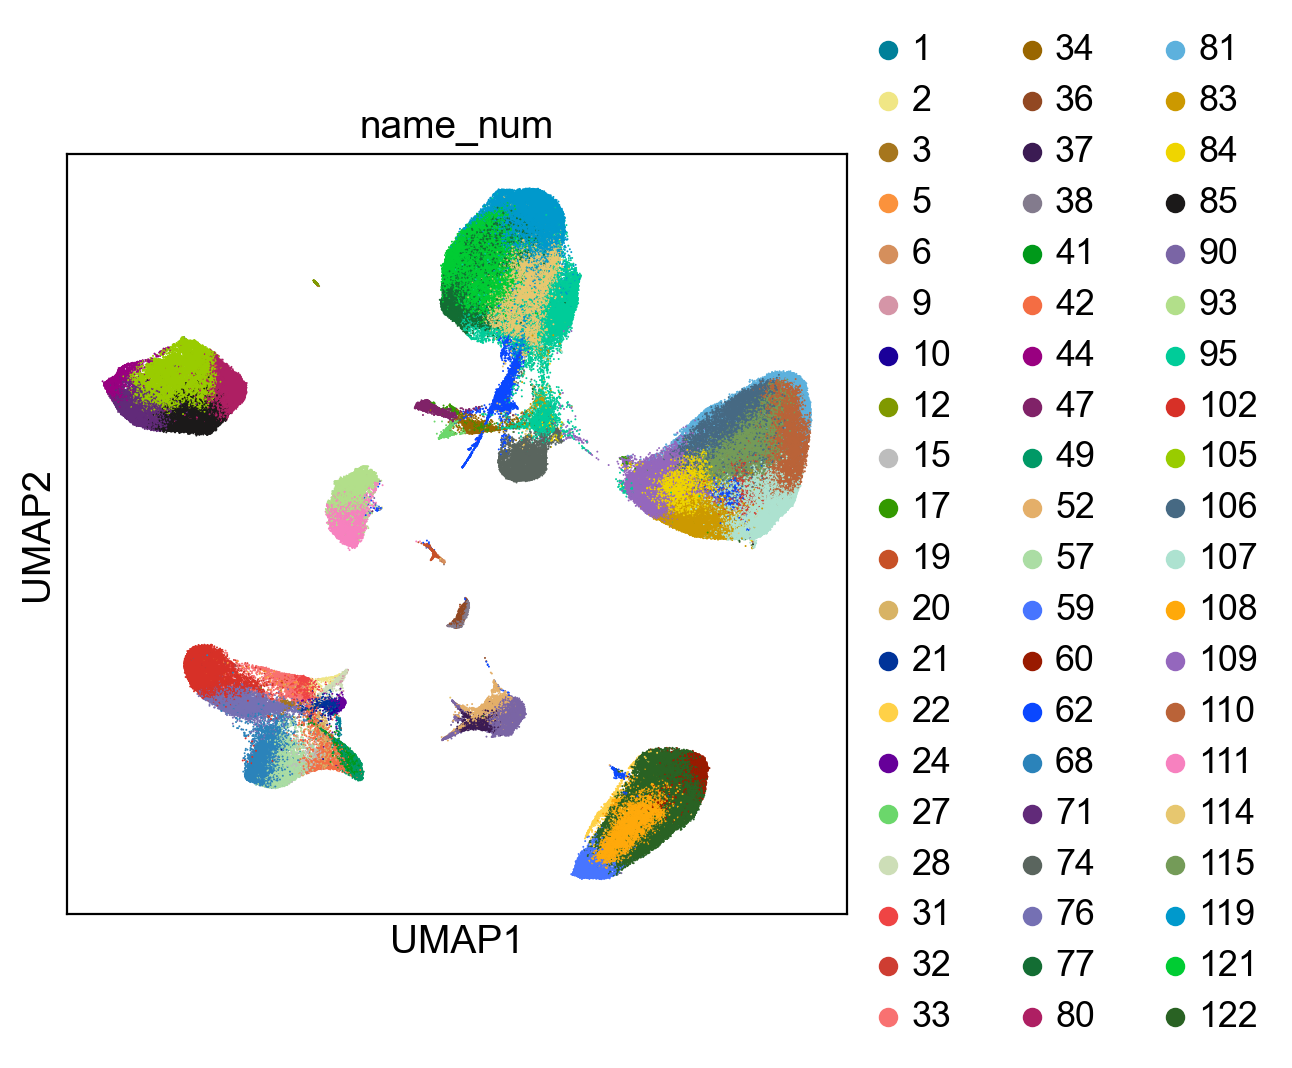

In [65]:
%matplotlib inline
sc.set_figure_params(dpi=100, figsize=(5,5))
sc.pl.umap(peak_mat, color='name_num', size=2)

In [37]:
sc_markers = diff_peak(peak_mat, best_leiden='Celltype_round4')

2025-11-05 19:40:08 - INFO - Selected 672561 features.


In [39]:
sc_markers.to_csv(f'./placeholder_output/raw_figure_output/Supp01/Immune_round4_diffpeaks.csv', index=False)

In [20]:
sc_markers = pd.read_csv('./placeholder_output/raw_figure_output/Supp01/Immune_round4_diffpeaks.csv')

sc_markers['group']  = (
        sc_markers['group']
        .astype(str)
        .str.replace('Macrophage_','Macorphage_',  regex=False)
)
sc_markers['group'] = new_celltype.loc[sc_markers['group'], 'cluster_num'].tolist()

In [ ]:
# # randomly sample cells
# import random
# random.seed(1234)
# select_bc = random.sample(list(peak_mat.obs_names), 5000)
# plot_mat = peak_mat[select_bc,:]
# plot_mat.layers['scale'] = sc.pp.scale(plot_mat, copy=True).X

In [ ]:

# sample by name_num for each group, ensure at least 100 cells per group (with replacement if insufficient), set random seed for reproducibility
seed = 1234
min_per_group = 100
rng = np.random.default_rng(seed)

selected_bcs = []
# use category order, if name_num is category then take categories, otherwise take unique value list
if hasattr(peak_mat.obs['name_num'], 'cat'):
    groups = peak_mat.obs['name_num'].cat.categories.tolist()
else:
    groups = peak_mat.obs['name_num'].unique().tolist()

for g in groups:
    # get all barcodes for this group (in peak_mat.obs_names order)
    mask = peak_mat.obs['name_num'] == g
    bcs = peak_mat.obs_names[mask].tolist()
    if len(bcs) == 0:
        continue
    if len(bcs) >= min_per_group:
        sel = rng.choice(bcs, size=min_per_group, replace=False).tolist()
    else:
        # allow replacement sampling when insufficient to ensure consistent and reproducible group sizes
        sel = rng.choice(bcs, size=min_per_group, replace=True).tolist()
    selected_bcs.extend(sel)

# if deduplication is desired, change to selected_bcs = list(dict.fromkeys(selected_bcs))
# maintain order then subset and copy as new AnnData
plot_mat = peak_mat[selected_bcs, :].copy()
plot_mat.layers['scale'] = sc.pp.scale(plot_mat, copy=True).X


2025-11-07 17:06:55 - INFO - maxp pruned
2025-11-07 17:06:55 - INFO - cmap pruned
2025-11-07 17:06:55 - INFO - kern dropped
2025-11-07 17:06:55 - INFO - post pruned
2025-11-07 17:06:55 - INFO - FFTM dropped
2025-11-07 17:06:55 - INFO - GPOS pruned
2025-11-07 17:06:55 - INFO - GSUB pruned
2025-11-07 17:06:55 - INFO - glyf pruned
2025-11-07 17:06:55 - INFO - Added gid0 to subset
2025-11-07 17:06:55 - INFO - Added first four glyphs to subset
2025-11-07 17:06:55 - INFO - Closing glyph list over 'MATH': 22 glyphs before
2025-11-07 17:06:55 - INFO - Glyph names: ['.notdef', '.null', 'a', 'e', 'eight', 'five', 'four', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'u', 'underscore', 'zero']
2025-11-07 17:06:55 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 66, 68, 72, 80, 81, 88, 3228]
2025-11-07 17:06:55 - INFO - Closed glyph list over 'MATH': 22 glyphs after
2025-11-07 17:06:55 - INFO - Glyph names: ['

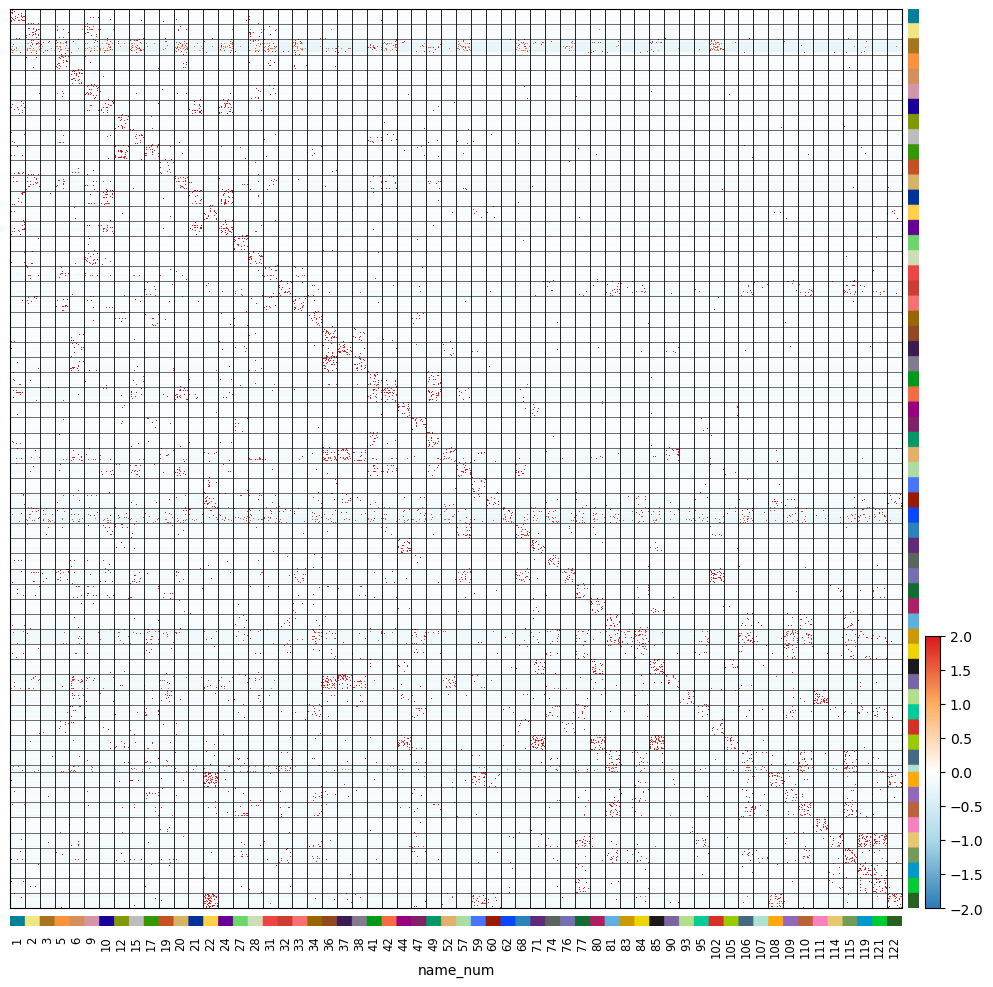

In [24]:
myht_save(plot_mat, sc_markers, 'name_num', fc=0.1, padj=0.05, pct1=0.05,
         pct2=0.05, figsize=(12,12), gene_size=6,#vmin=-1, vmax=1,
         topn=50, orderby='logfoldchanges', shift=0.5, genesymboe=None, show_gene_labels=False,
         save_path='./placeholder_output/raw_figure_output/Supp01/Immune_round4_peak_ht.pdf', dpi=500)

# Epithelial

In [25]:
base_path='./placeholder_analysis/round_cluster02/round1/Endothelium/'
peak_mat = sc.read_h5ad(f'{base_path}/peak_mat_ann.h5ad')
import pandas as pd

csv_path = './placeholder_analysis/round_cluster02/merge/cell_meta.csv'
tmp_umap = pd.read_csv(csv_path, index_col=0)


# keep cells existing in peak_mat, in peak_mat order
tmp_same_bc = [bc for bc in peak_mat.obs_names if bc in tmp_umap.index]


# subset and ensure it is a copy
peak_mat = peak_mat[tmp_same_bc, :].copy()


In [26]:
peak_mat

AnnData object with n_obs × n_vars = 170835 × 679511
    obs: 'sample', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6', 'leiden_1.7', 'leiden_1.8', 'leiden_1.9', 'leiden_2.0', 'n_fragment', 'n_peaks', 'tsse', 'Frip', 'leiden_0.1_round1', 'leiden_0.2_round1', 'leiden_0.3_round1', 'leiden_0.4_round1', 'leiden_0.5_round1', 'leiden_0.6_round1', 'leiden_0.7_round1', 'leiden_0.8_round1', 'leiden_0.9_round1', 'leiden_1.0_round1', 'leiden_1.1_round1', 'leiden_1.2_round1', 'leiden_1.3_round1', 'leiden_1.4_round1', 'leiden_1.5_round1', 'leiden_1.6_round1', 'leiden_1.7_round1', 'leiden_1.8_round1', 'leiden_1.9_round1', 'leiden_2.0_round1', 'Celltype_round1', 'leiden_0.1_round2', 'leiden_0.2_round2', 'leiden_0.3_round2', 'leiden_0.4_round2', 'leiden_0.5_round2', 'leiden_0.6_round2', 'leiden_0.7_round2', 'leiden_0.8_round2', 

In [27]:
tmp_umap = tmp_umap.loc[peak_mat.obs_names]
peak_mat.obs['Celltype_round4'] = tmp_umap['Celltype_round4'].values
peak_mat.obs['name_num'] = new_celltype.loc[tmp_umap['Celltype_round4'].values, 'cluster_num'].tolist()
peak_mat.obs['name_num'] = peak_mat.obs['name_num'].astype('category')
peak_mat.uns['name_num_colors'] = new_celltype_color.loc[peak_mat.obs['name_num'].cat.categories.tolist(),'color'].tolist()

... storing 'Celltype_round4' as categorical


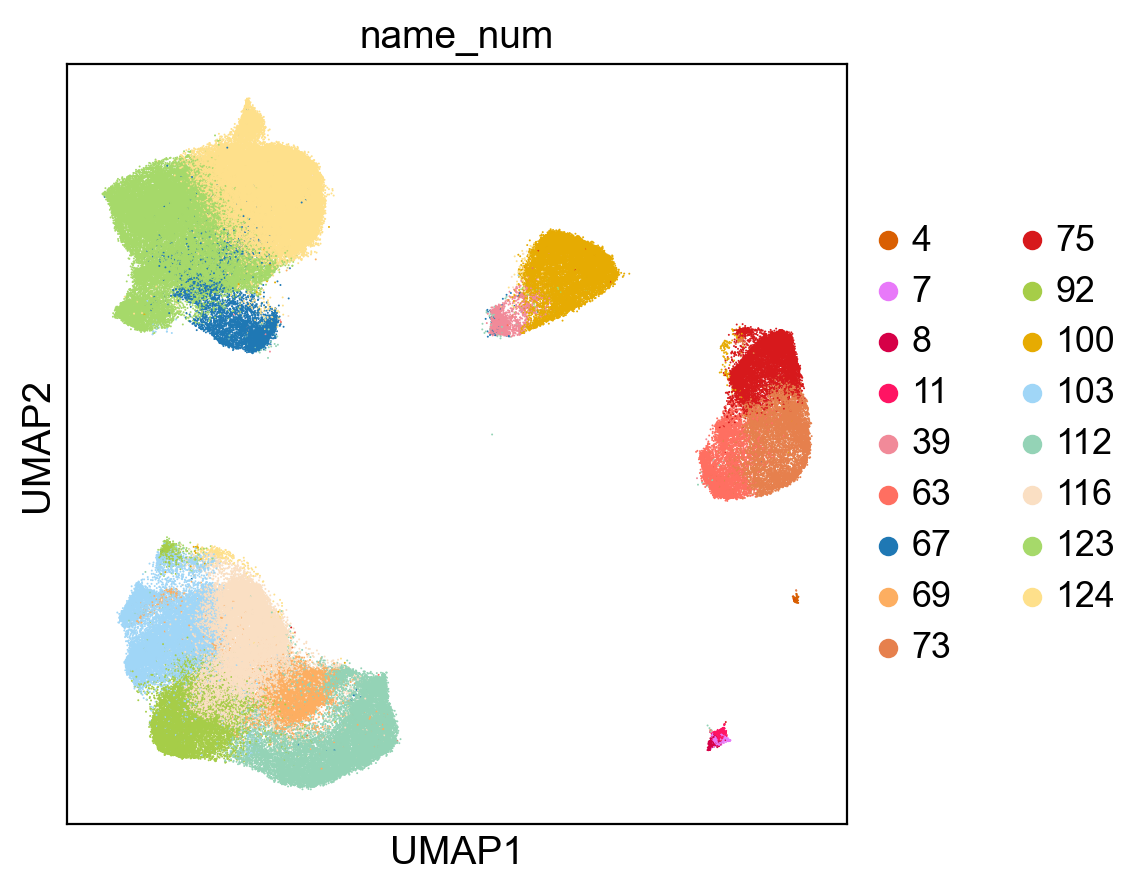

In [28]:
%matplotlib inline
sc.set_figure_params(dpi=100, figsize=(5,5))
sc.pl.umap(peak_mat, color='name_num', size=2)

In [51]:
sc_markers = diff_peak(peak_mat, best_leiden='Celltype_round4')

2025-11-05 20:20:23 - INFO - Selected 672542 features.


In [52]:
sc_markers.to_csv(f'./placeholder_output/raw_figure_output/Supp01/Epi_round4_diffpeaks.csv', index=False)

In [29]:
sc_markers = pd.read_csv('./placeholder_output/raw_figure_output/Supp01/Epi_round4_diffpeaks.csv')

sc_markers['group']  = (
        sc_markers['group']
        .astype(str)
        .str.replace('Macrophage_','Macorphage_',  regex=False)
)
sc_markers['group'] = new_celltype.loc[sc_markers['group'], 'cluster_num'].tolist()


In [30]:

# sample by name_num for each group, ensure at least 100 cells per group (with replacement if insufficient), set random seed for reproducibility
seed = 1234
min_per_group = 100
rng = np.random.default_rng(seed)

selected_bcs = []
# use category order, if name_num is category then take categories, otherwise take unique value list
if hasattr(peak_mat.obs['name_num'], 'cat'):
    groups = peak_mat.obs['name_num'].cat.categories.tolist()
else:
    groups = peak_mat.obs['name_num'].unique().tolist()

for g in groups:
    # get all barcodes for this group (in peak_mat.obs_names order)
    mask = peak_mat.obs['name_num'] == g
    bcs = peak_mat.obs_names[mask].tolist()
    if len(bcs) == 0:
        continue
    if len(bcs) >= min_per_group:
        sel = rng.choice(bcs, size=min_per_group, replace=False).tolist()
    else:
        # allow replacement sampling when insufficient to ensure consistent and reproducible group sizes
        sel = rng.choice(bcs, size=min_per_group, replace=True).tolist()
    selected_bcs.extend(sel)

# if deduplication is desired, change to selected_bcs = list(dict.fromkeys(selected_bcs))
# maintain order then subset and copy as new AnnData
plot_mat = peak_mat[selected_bcs, :].copy()
plot_mat.layers['scale'] = sc.pp.scale(plot_mat, copy=True).X


2025-11-07 17:13:09 - INFO - maxp pruned
2025-11-07 17:13:09 - INFO - LTSH dropped
2025-11-07 17:13:09 - INFO - cmap pruned
2025-11-07 17:13:09 - INFO - kern dropped
2025-11-07 17:13:09 - INFO - post pruned
2025-11-07 17:13:09 - INFO - PCLT dropped
2025-11-07 17:13:09 - INFO - JSTF dropped
2025-11-07 17:13:09 - INFO - DSIG dropped
2025-11-07 17:13:09 - INFO - GPOS pruned
2025-11-07 17:13:09 - INFO - GSUB pruned
2025-11-07 17:13:09 - INFO - glyf pruned
2025-11-07 17:13:09 - INFO - Added gid0 to subset
2025-11-07 17:13:09 - INFO - Added first four glyphs to subset
2025-11-07 17:13:09 - INFO - Closing glyph list over 'GSUB': 21 glyphs before
2025-11-07 17:13:09 - INFO - Glyph names: ['.notdef', '.null', 'a', 'e', 'eight', 'five', 'four', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'u', 'underscore', 'zero']
2025-11-07 17:13:09 - INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 66, 68, 72, 80, 81, 88, 237]
2025-11-0

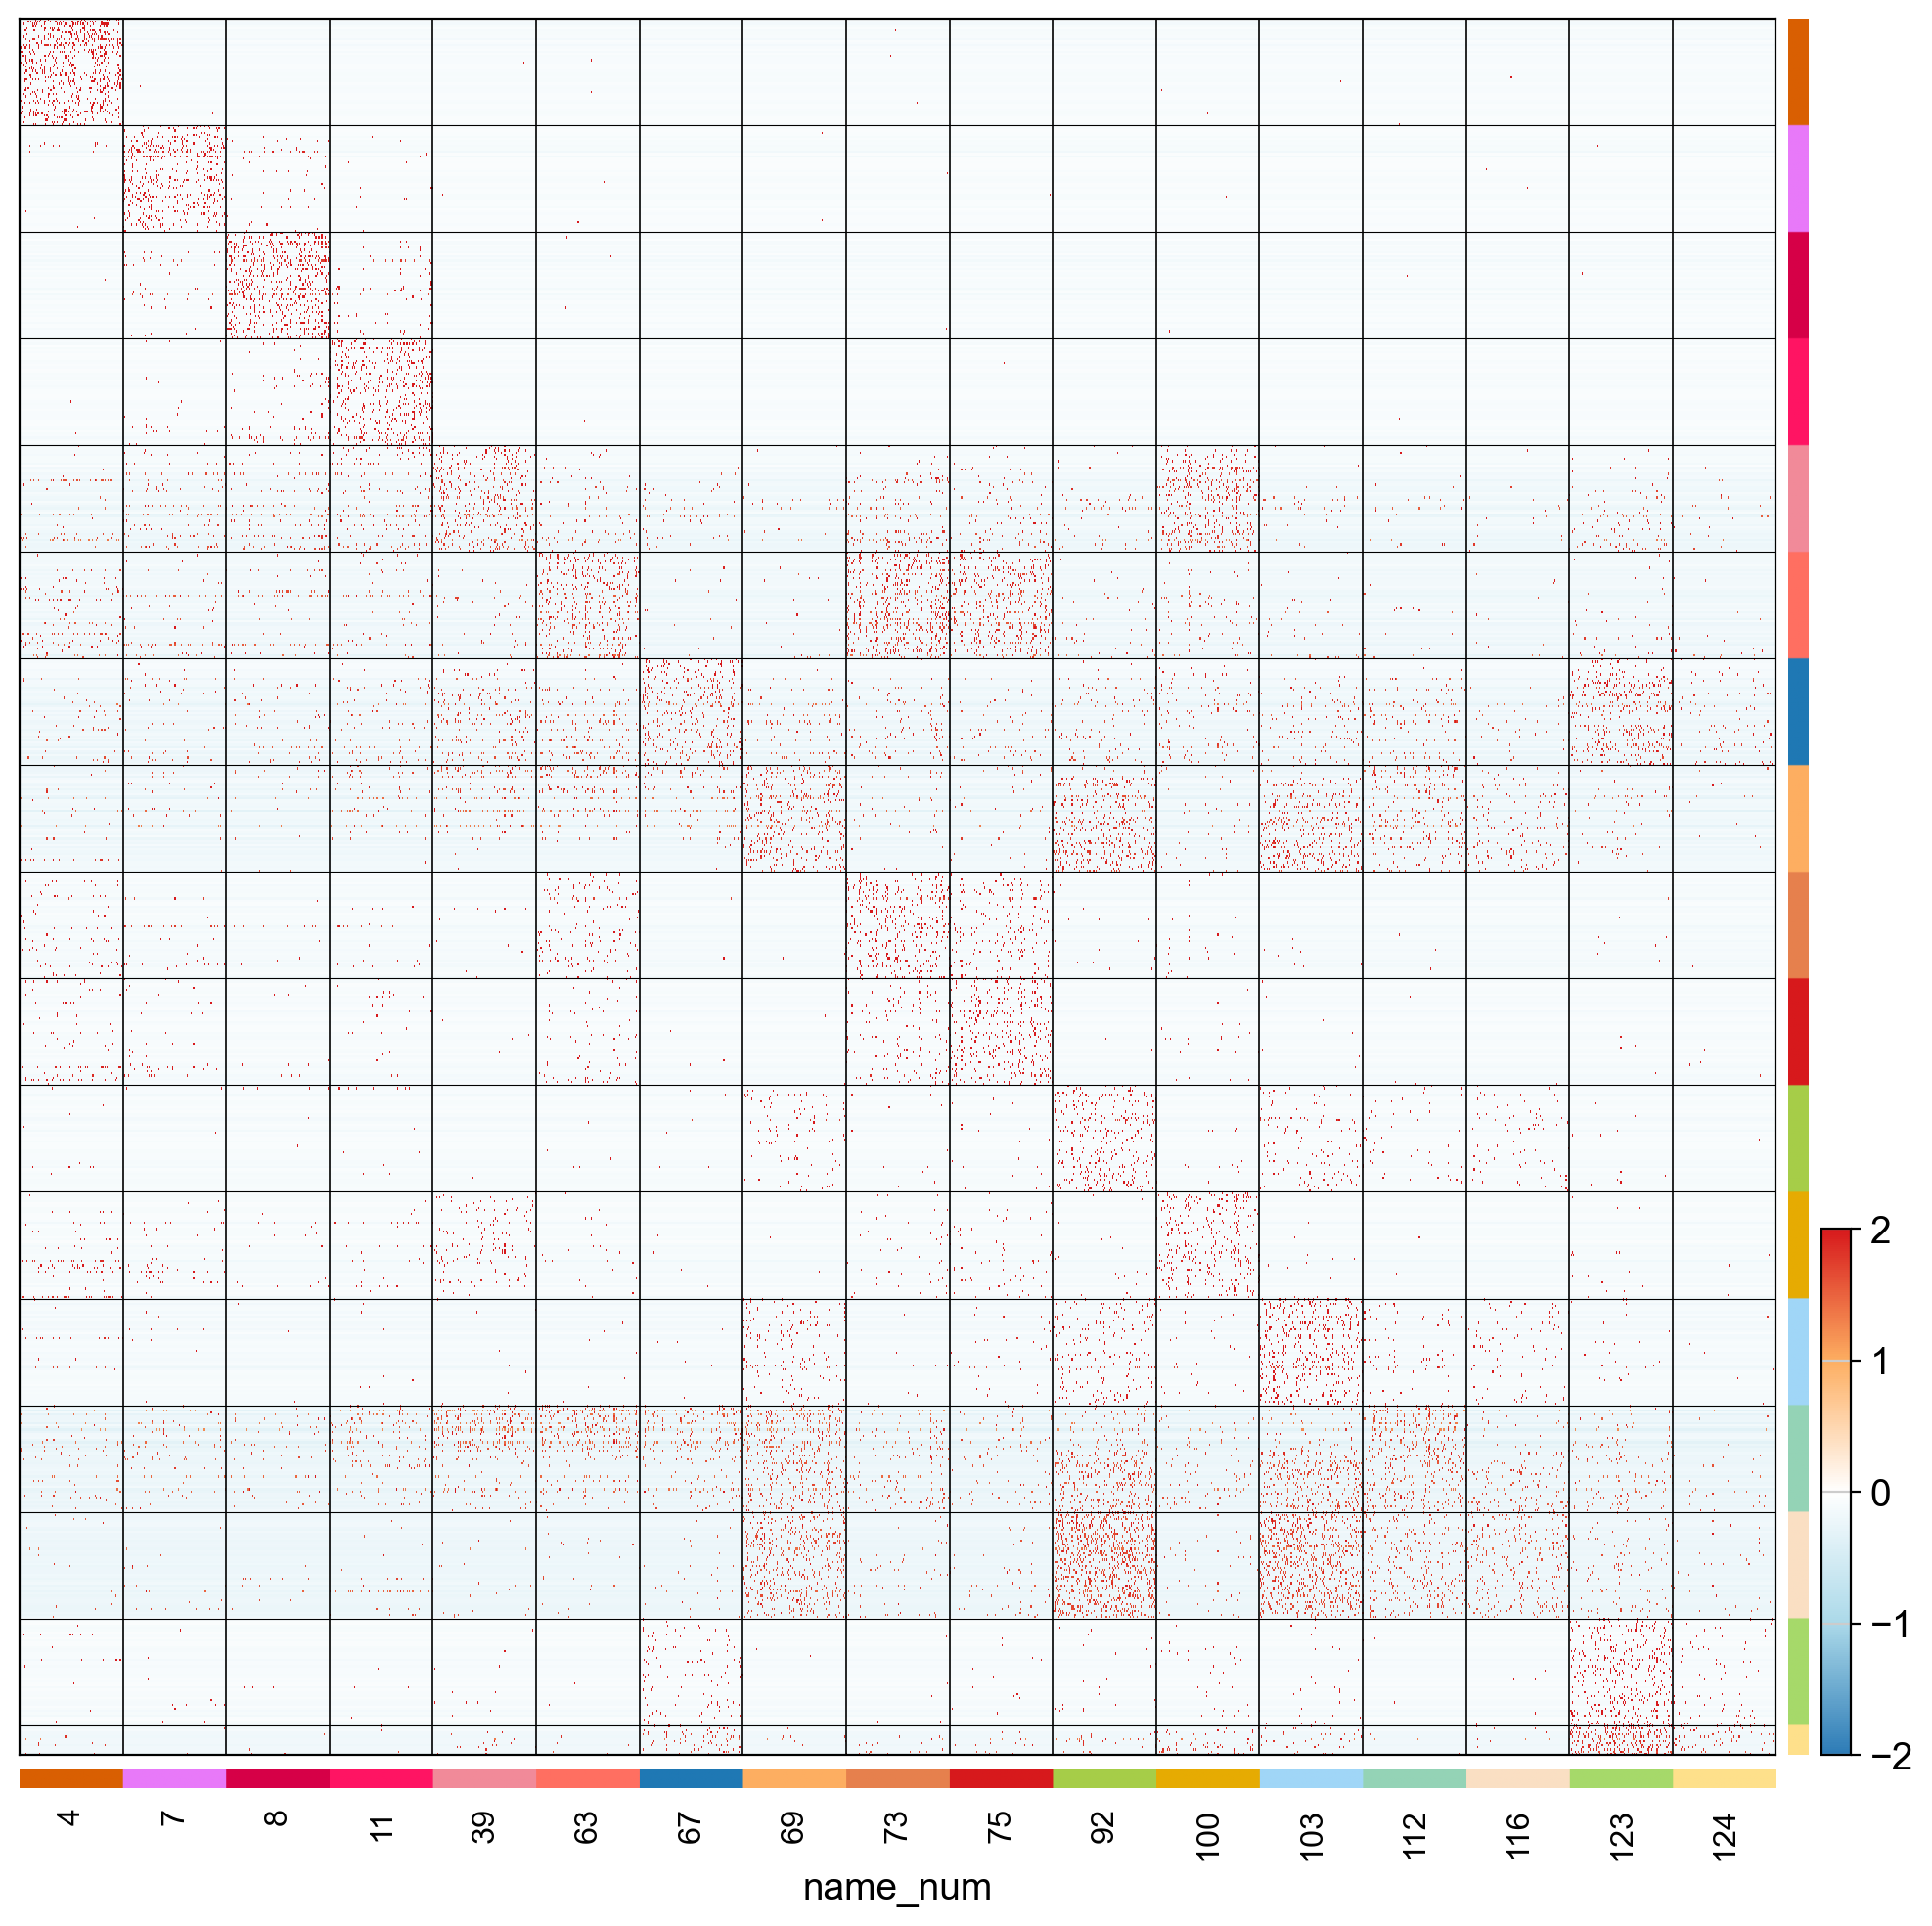

In [31]:
myht_save(plot_mat, sc_markers, 'name_num', fc=0.1, padj=0.05, pct1=0.05,
         pct2=0.05, figsize=(12,12), gene_size=6,#vmin=-1, vmax=1,
         topn=50, orderby='logfoldchanges', shift=0.5, genesymboe=None, show_gene_labels=False,
         save_path='./placeholder_output/raw_figure_output/Supp01/Epi_round4_peak_ht.pdf', dpi=500)

# Endothelium

In [32]:
base_path='./placeholder_analysis/round_cluster02/round1/Epithelium/'
peak_mat = sc.read_h5ad(f'{base_path}/peak_mat_ann.h5ad')
import pandas as pd

csv_path = './placeholder_analysis/round_cluster02/merge/cell_meta.csv'
tmp_umap = pd.read_csv(csv_path, index_col=0)


# keep cells existing in peak_mat, in peak_mat order
tmp_same_bc = [bc for bc in peak_mat.obs_names if bc in tmp_umap.index]


# subset and ensure it is a copy
peak_mat = peak_mat[tmp_same_bc, :].copy()


In [ ]:
peak_mat

AnnData object with n_obs × n_vars = 361275 × 679511
    obs: 'sample', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6', 'leiden_1.7', 'leiden_1.8', 'leiden_1.9', 'leiden_2.0', 'n_fragment', 'n_peaks', 'tsse', 'Frip', 'leiden_0.1_round1', 'leiden_0.2_round1', 'leiden_0.3_round1', 'leiden_0.4_round1', 'leiden_0.5_round1', 'leiden_0.6_round1', 'leiden_0.7_round1', 'leiden_0.8_round1', 'leiden_0.9_round1', 'leiden_1.0_round1', 'leiden_1.1_round1', 'leiden_1.2_round1', 'leiden_1.3_round1', 'leiden_1.4_round1', 'leiden_1.5_round1', 'leiden_1.6_round1', 'leiden_1.7_round1', 'leiden_1.8_round1', 'leiden_1.9_round1', 'leiden_2.0_round1', 'Celltype_round1', 'leiden', 'leiden_0.1_round2', 'leiden_0.2_round2', 'leiden_0.3_round2', 'leiden_0.4_round2', 'leiden_0.5_round2', 'leiden_0.6_round2', 'leiden_0.7_round2', 'leiden_0.8

In [33]:
tmp_umap = tmp_umap.loc[peak_mat.obs_names]
peak_mat.obs['Celltype_round4'] = tmp_umap['Celltype_round4'].values
peak_mat.obs['name_num'] = new_celltype.loc[tmp_umap['Celltype_round4'].values, 'cluster_num'].tolist()
peak_mat.obs['name_num'] = peak_mat.obs['name_num'].astype('category')
peak_mat.uns['name_num_colors'] = new_celltype_color.loc[peak_mat.obs['name_num'].cat.categories.tolist(),'color'].tolist()

... storing 'Celltype_round4' as categorical


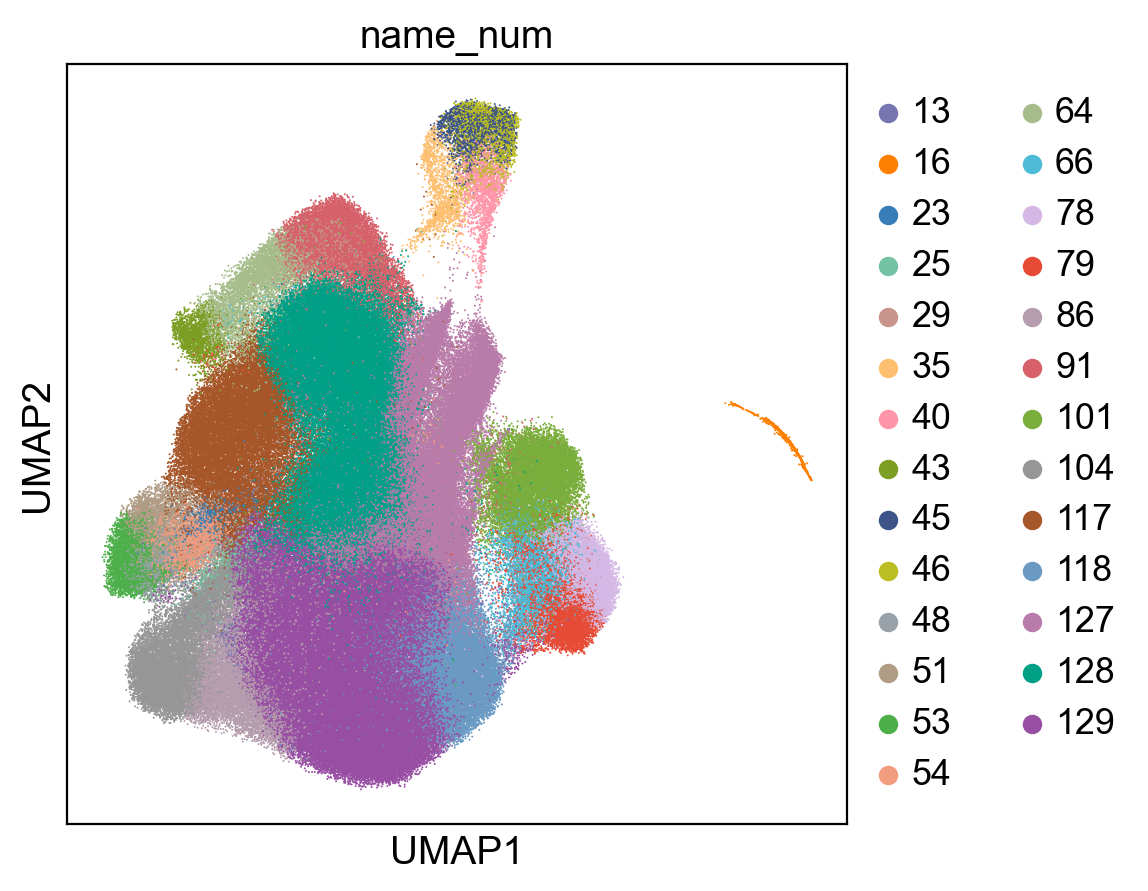

In [34]:
%matplotlib inline
sc.set_figure_params(dpi=100, figsize=(5,5))
sc.pl.umap(peak_mat, color='name_num', size=2)

In [ ]:
sc_markers = diff_peak(peak_mat, best_leiden='Celltype_round4')

2025-11-06 07:28:59 - INFO - Selected 672559 features.


In [63]:
sc_markers.to_csv(f'./placeholder_output/raw_figure_output/Supp01/Endo_round4_diffpeaks.csv', index=False)

In [36]:
sc_markers = pd.read_csv('./placeholder_output/raw_figure_output/Supp01/Endo_round4_diffpeaks.csv')

sc_markers['group']  = (
        sc_markers['group']
        .astype(str)
        .str.replace('Macrophage_','Macorphage_',  regex=False)
)
sc_markers['group'] = new_celltype.loc[sc_markers['group'], 'cluster_num'].tolist()


In [37]:

# sample by name_num for each group, ensure at least 100 cells per group (with replacement if insufficient), set random seed for reproducibility
seed = 1234
min_per_group = 100
rng = np.random.default_rng(seed)

selected_bcs = []
# use category order, if name_num is category then take categories, otherwise take unique value list
if hasattr(peak_mat.obs['name_num'], 'cat'):
    groups = peak_mat.obs['name_num'].cat.categories.tolist()
else:
    groups = peak_mat.obs['name_num'].unique().tolist()

for g in groups:
    # get all barcodes for this group (in peak_mat.obs_names order)
    mask = peak_mat.obs['name_num'] == g
    bcs = peak_mat.obs_names[mask].tolist()
    if len(bcs) == 0:
        continue
    if len(bcs) >= min_per_group:
        sel = rng.choice(bcs, size=min_per_group, replace=False).tolist()
    else:
        # allow replacement sampling when insufficient to ensure consistent and reproducible group sizes
        sel = rng.choice(bcs, size=min_per_group, replace=True).tolist()
    selected_bcs.extend(sel)

# if deduplication is desired, change to selected_bcs = list(dict.fromkeys(selected_bcs))
# maintain order then subset and copy as new AnnData
plot_mat = peak_mat[selected_bcs, :].copy()
plot_mat.layers['scale'] = sc.pp.scale(plot_mat, copy=True).X


2025-11-07 17:20:27 - INFO - maxp pruned
2025-11-07 17:20:27 - INFO - LTSH dropped
2025-11-07 17:20:27 - INFO - cmap pruned
2025-11-07 17:20:27 - INFO - kern dropped
2025-11-07 17:20:27 - INFO - post pruned
2025-11-07 17:20:27 - INFO - PCLT dropped
2025-11-07 17:20:27 - INFO - JSTF dropped
2025-11-07 17:20:27 - INFO - DSIG dropped
2025-11-07 17:20:27 - INFO - GPOS pruned
2025-11-07 17:20:27 - INFO - GSUB pruned
2025-11-07 17:20:27 - INFO - glyf pruned
2025-11-07 17:20:27 - INFO - Added gid0 to subset
2025-11-07 17:20:27 - INFO - Added first four glyphs to subset
2025-11-07 17:20:27 - INFO - Closing glyph list over 'GSUB': 21 glyphs before
2025-11-07 17:20:27 - INFO - Glyph names: ['.notdef', '.null', 'a', 'e', 'eight', 'five', 'four', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'u', 'underscore', 'zero']
2025-11-07 17:20:27 - INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 66, 68, 72, 80, 81, 88, 237]
2025-11-0

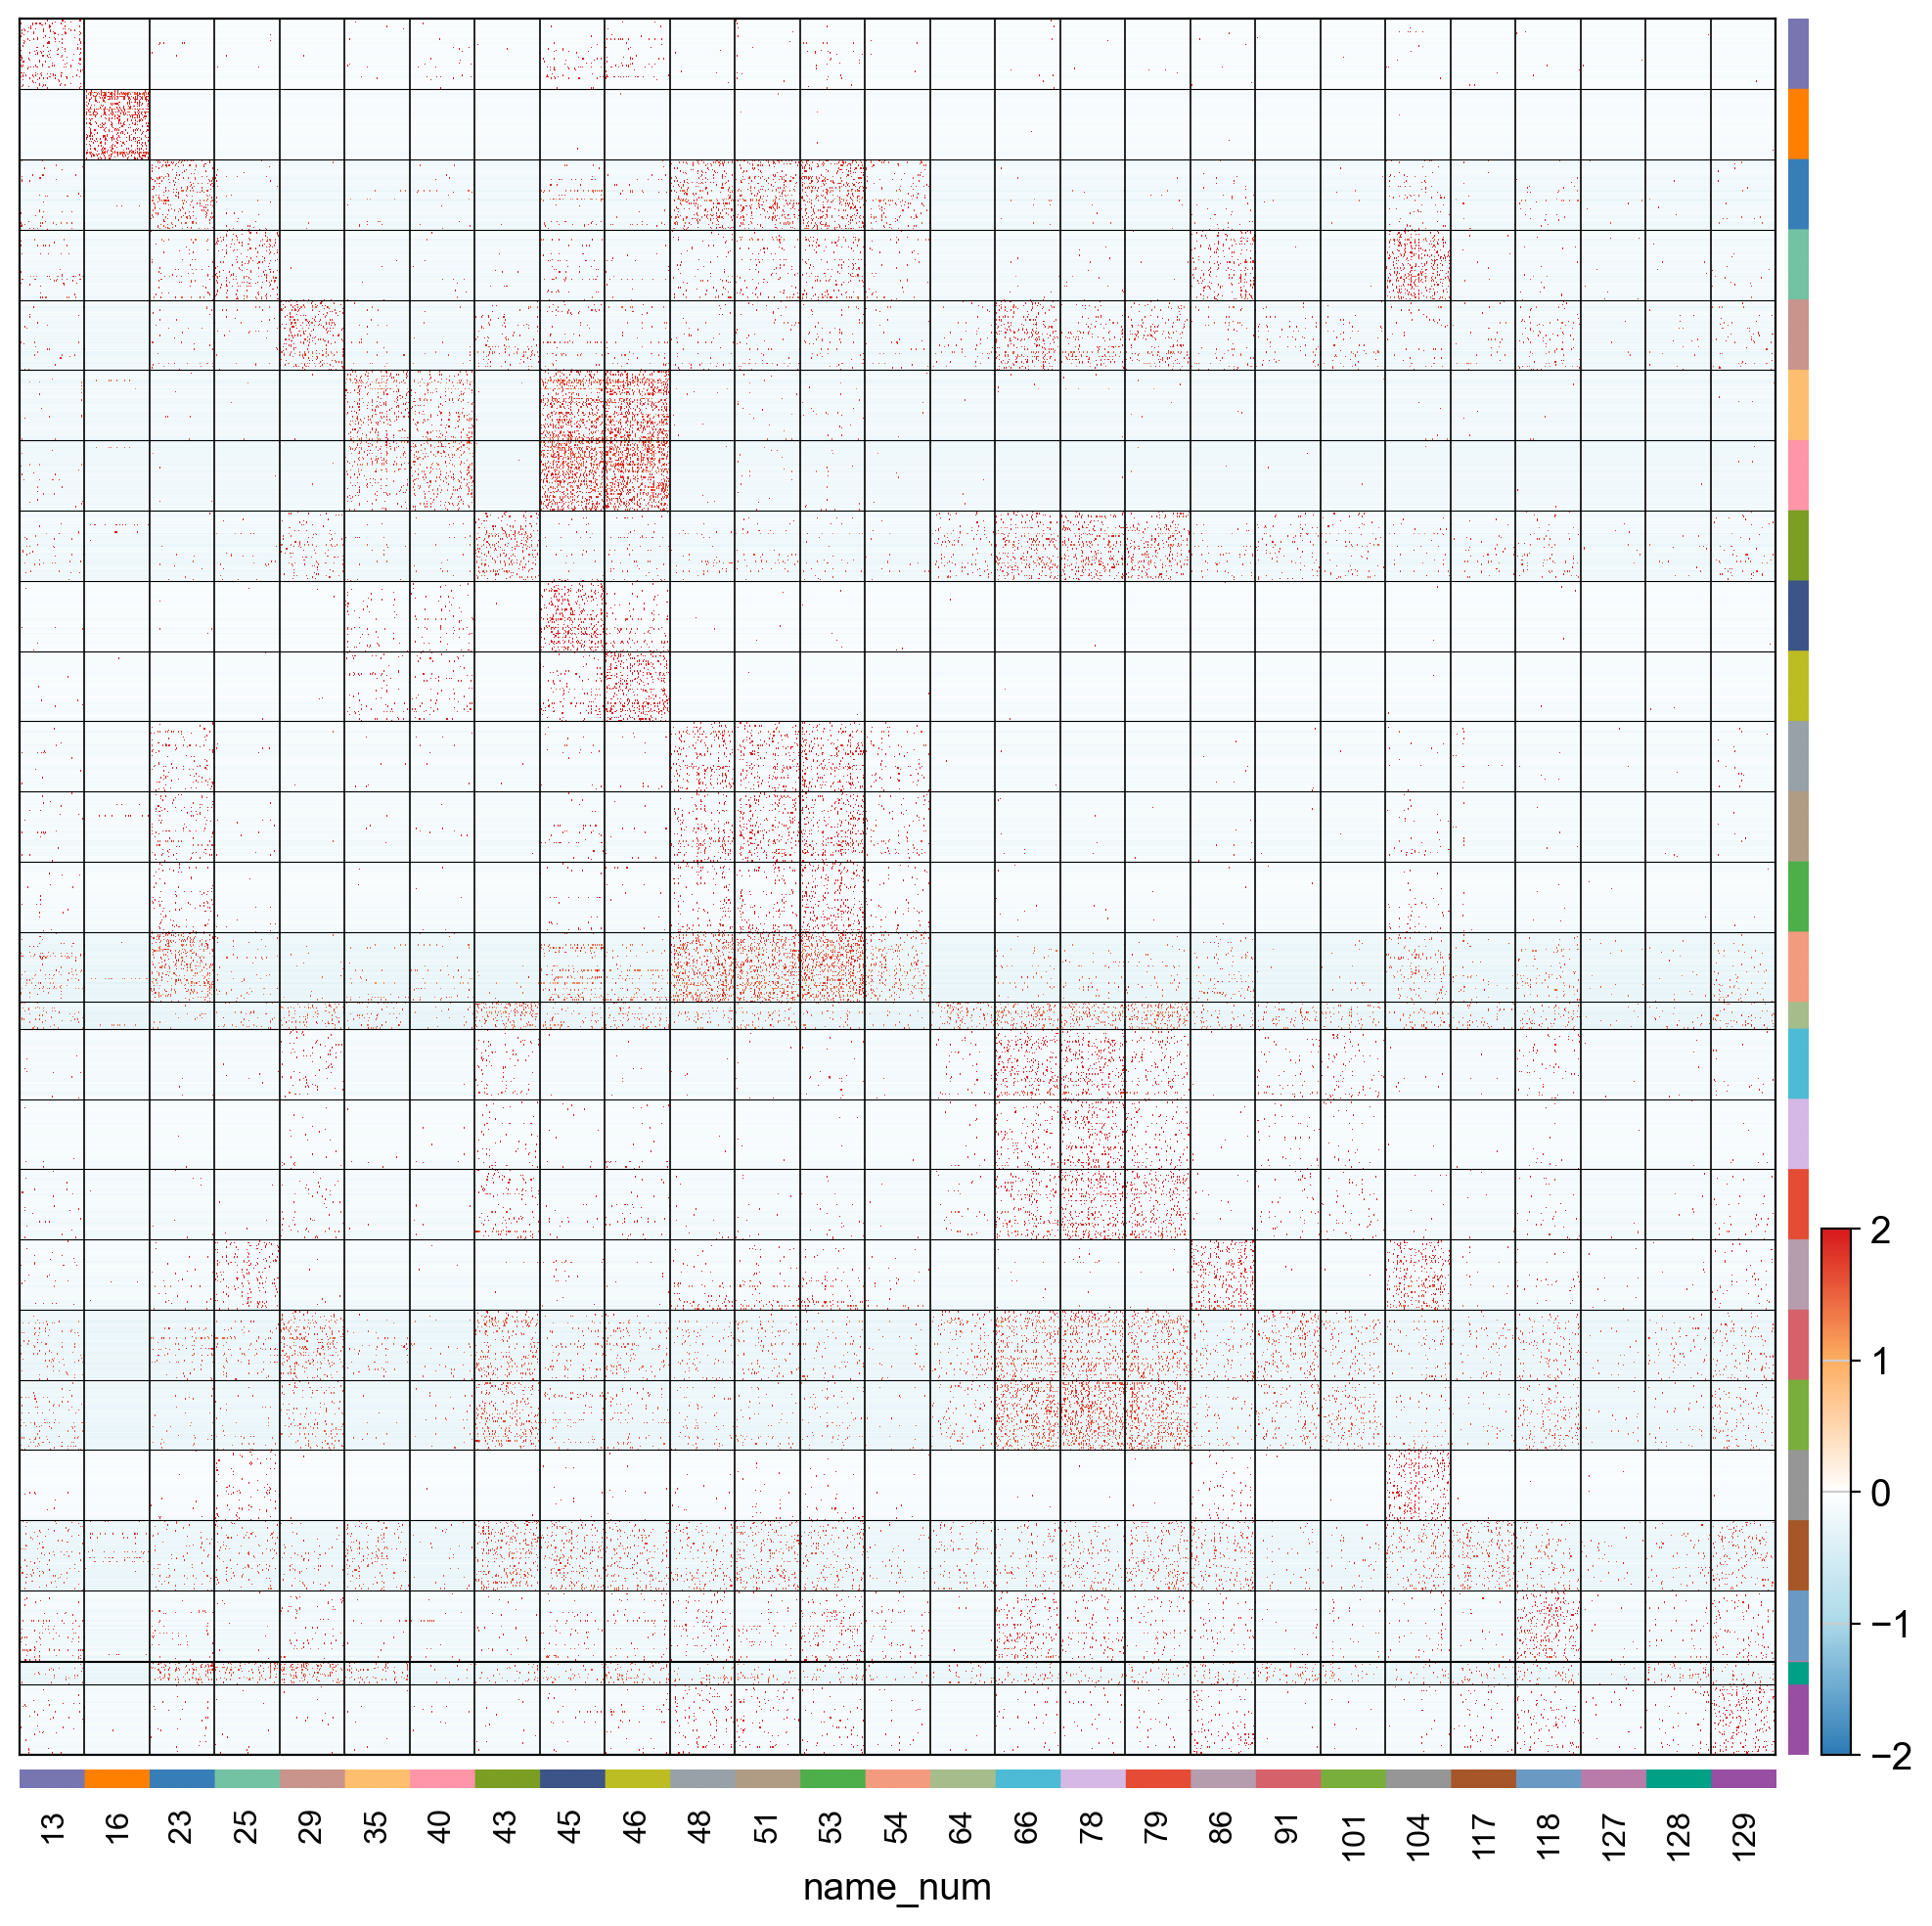

In [38]:
myht_save(plot_mat, sc_markers, 'name_num', fc=0.1, padj=0.05, pct1=0.05,
         pct2=0.05, figsize=(12,12), gene_size=6,#vmin=-1, vmax=1,
         topn=50, orderby='logfoldchanges', shift=0.5, genesymboe=None, show_gene_labels=False,
         save_path='./placeholder_output/raw_figure_output/Supp01/Endo_round4_peak_ht.pdf', dpi=500)

# Stroma

In [40]:
base_path='./placeholder_analysis/round_cluster02/round1/Stroma/'
peak_mat = sc.read_h5ad(f'{base_path}/peak_mat_ann.h5ad')
import pandas as pd

csv_path = './placeholder_analysis/round_cluster02/merge/cell_meta.csv'
tmp_umap = pd.read_csv(csv_path, index_col=0)


# keep cells existing in peak_mat, in peak_mat order
tmp_same_bc = [bc for bc in peak_mat.obs_names if bc in tmp_umap.index]


# subset and ensure it is a copy
peak_mat = peak_mat[tmp_same_bc, :]#.copy()


In [41]:
peak_mat

View of AnnData object with n_obs × n_vars = 262996 × 679511
    obs: 'sample', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6', 'leiden_1.7', 'leiden_1.8', 'leiden_1.9', 'leiden_2.0', 'n_fragment', 'n_peaks', 'tsse', 'Frip', 'leiden_0.1_round1', 'leiden_0.2_round1', 'leiden_0.3_round1', 'leiden_0.4_round1', 'leiden_0.5_round1', 'leiden_0.6_round1', 'leiden_0.7_round1', 'leiden_0.8_round1', 'leiden_0.9_round1', 'leiden_1.0_round1', 'leiden_1.1_round1', 'leiden_1.2_round1', 'leiden_1.3_round1', 'leiden_1.4_round1', 'leiden_1.5_round1', 'leiden_1.6_round1', 'leiden_1.7_round1', 'leiden_1.8_round1', 'leiden_1.9_round1', 'leiden_2.0_round1', 'Celltype_round1', 'leiden_0.1_round2', 'leiden_0.2_round2', 'leiden_0.3_round2', 'leiden_0.4_round2', 'leiden_0.5_round2', 'leiden_0.6_round2', 'leiden_0.7_round2', 'leiden_0.8_r

In [42]:
tmp_umap = tmp_umap.loc[peak_mat.obs_names]
peak_mat.obs['Celltype_round4'] = tmp_umap['Celltype_round4'].values
peak_mat.obs['name_num'] = new_celltype.loc[tmp_umap['Celltype_round4'].values, 'cluster_num'].tolist()
peak_mat.obs['name_num'] = peak_mat.obs['name_num'].astype('category')
peak_mat.uns['name_num_colors'] = new_celltype_color.loc[peak_mat.obs['name_num'].cat.categories.tolist(),'color'].tolist()

... storing 'Celltype_round4' as categorical


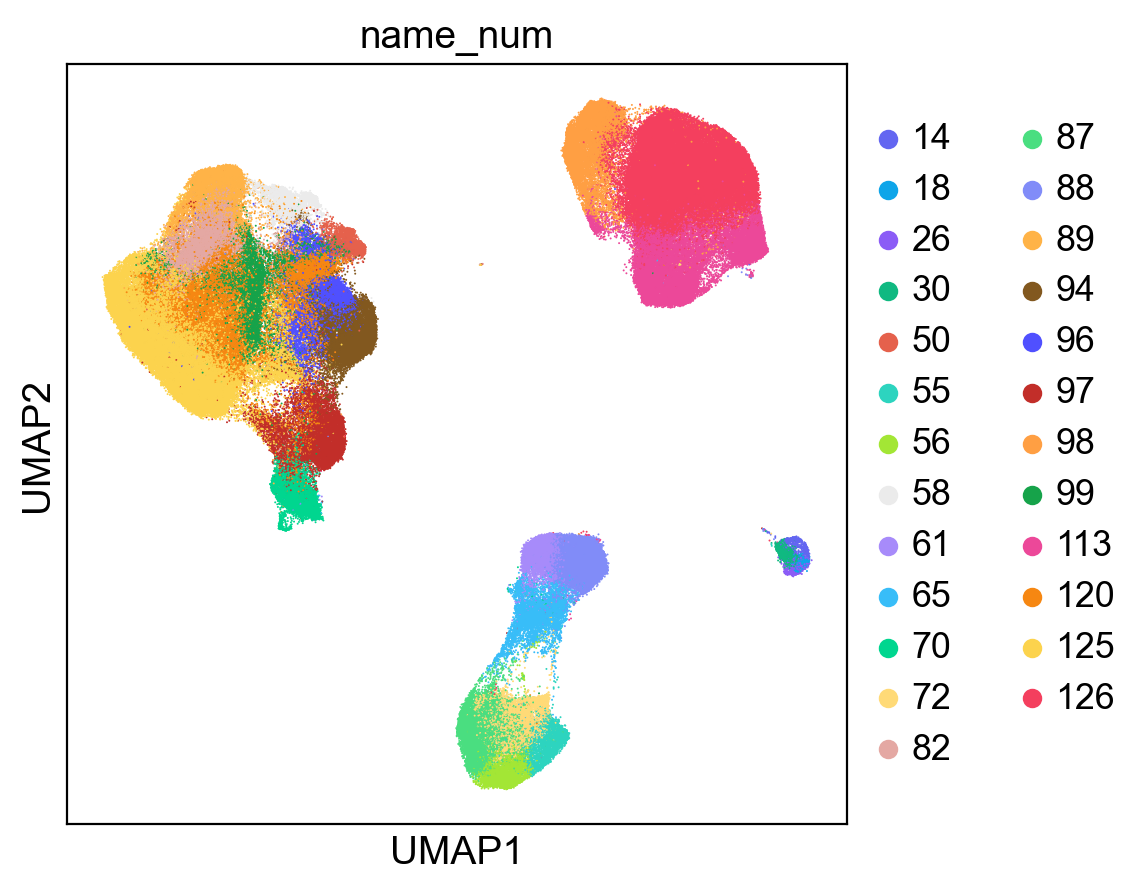

In [43]:
%matplotlib inline
sc.set_figure_params(dpi=100, figsize=(5,5))
sc.pl.umap(peak_mat, color='name_num', size=2)

In [70]:
sc_markers = diff_peak(peak_mat, best_leiden='Celltype_round4')

2025-11-06 07:45:45 - INFO - Selected 672556 features.


In [71]:
sc_markers.to_csv(f'./placeholder_output/raw_figure_output/Supp01/Stroma_round4_diffpeaks.csv', index=False)

In [44]:
sc_markers = pd.read_csv('./placeholder_output/raw_figure_output/Supp01/Stroma_round4_diffpeaks.csv')

sc_markers['group']  = (
        sc_markers['group']
        .astype(str)
        .str.replace('Macrophage_','Macorphage_',  regex=False)
)
sc_markers['group'] = new_celltype.loc[sc_markers['group'], 'cluster_num'].tolist()

# sample by name_num for each group, ensure at least 100 cells per group (with replacement if insufficient), set random seed for reproducibility
seed = 1234
min_per_group = 100
rng = np.random.default_rng(seed)

selected_bcs = []
# use category order, if name_num is category then take categories, otherwise take unique value list
if hasattr(peak_mat.obs['name_num'], 'cat'):
    groups = peak_mat.obs['name_num'].cat.categories.tolist()
else:
    groups = peak_mat.obs['name_num'].unique().tolist()

for g in groups:
    # get all barcodes for this group (in peak_mat.obs_names order)
    mask = peak_mat.obs['name_num'] == g
    bcs = peak_mat.obs_names[mask].tolist()
    if len(bcs) == 0:
        continue
    if len(bcs) >= min_per_group:
        sel = rng.choice(bcs, size=min_per_group, replace=False).tolist()
    else:
        # allow replacement sampling when insufficient to ensure consistent and reproducible group sizes
        sel = rng.choice(bcs, size=min_per_group, replace=True).tolist()
    selected_bcs.extend(sel)

# if deduplication is desired, change to selected_bcs = list(dict.fromkeys(selected_bcs))
# maintain order then subset and copy as new AnnData
plot_mat = peak_mat[selected_bcs, :].copy()
plot_mat.layers['scale'] = sc.pp.scale(plot_mat, copy=True).X


2025-11-07 17:38:50 - INFO - maxp pruned
2025-11-07 17:38:50 - INFO - LTSH dropped
2025-11-07 17:38:50 - INFO - cmap pruned
2025-11-07 17:38:50 - INFO - kern dropped
2025-11-07 17:38:50 - INFO - post pruned
2025-11-07 17:38:50 - INFO - PCLT dropped
2025-11-07 17:38:50 - INFO - JSTF dropped
2025-11-07 17:38:50 - INFO - DSIG dropped
2025-11-07 17:38:50 - INFO - GPOS pruned
2025-11-07 17:38:50 - INFO - GSUB pruned
2025-11-07 17:38:54 - INFO - glyf pruned
2025-11-07 17:38:54 - INFO - Added gid0 to subset
2025-11-07 17:38:54 - INFO - Added first four glyphs to subset
2025-11-07 17:38:54 - INFO - Closing glyph list over 'GSUB': 21 glyphs before
2025-11-07 17:38:54 - INFO - Glyph names: ['.notdef', '.null', 'a', 'e', 'eight', 'five', 'four', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'u', 'underscore', 'zero']
2025-11-07 17:38:54 - INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 66, 68, 72, 80, 81, 88, 237]
2025-11-0

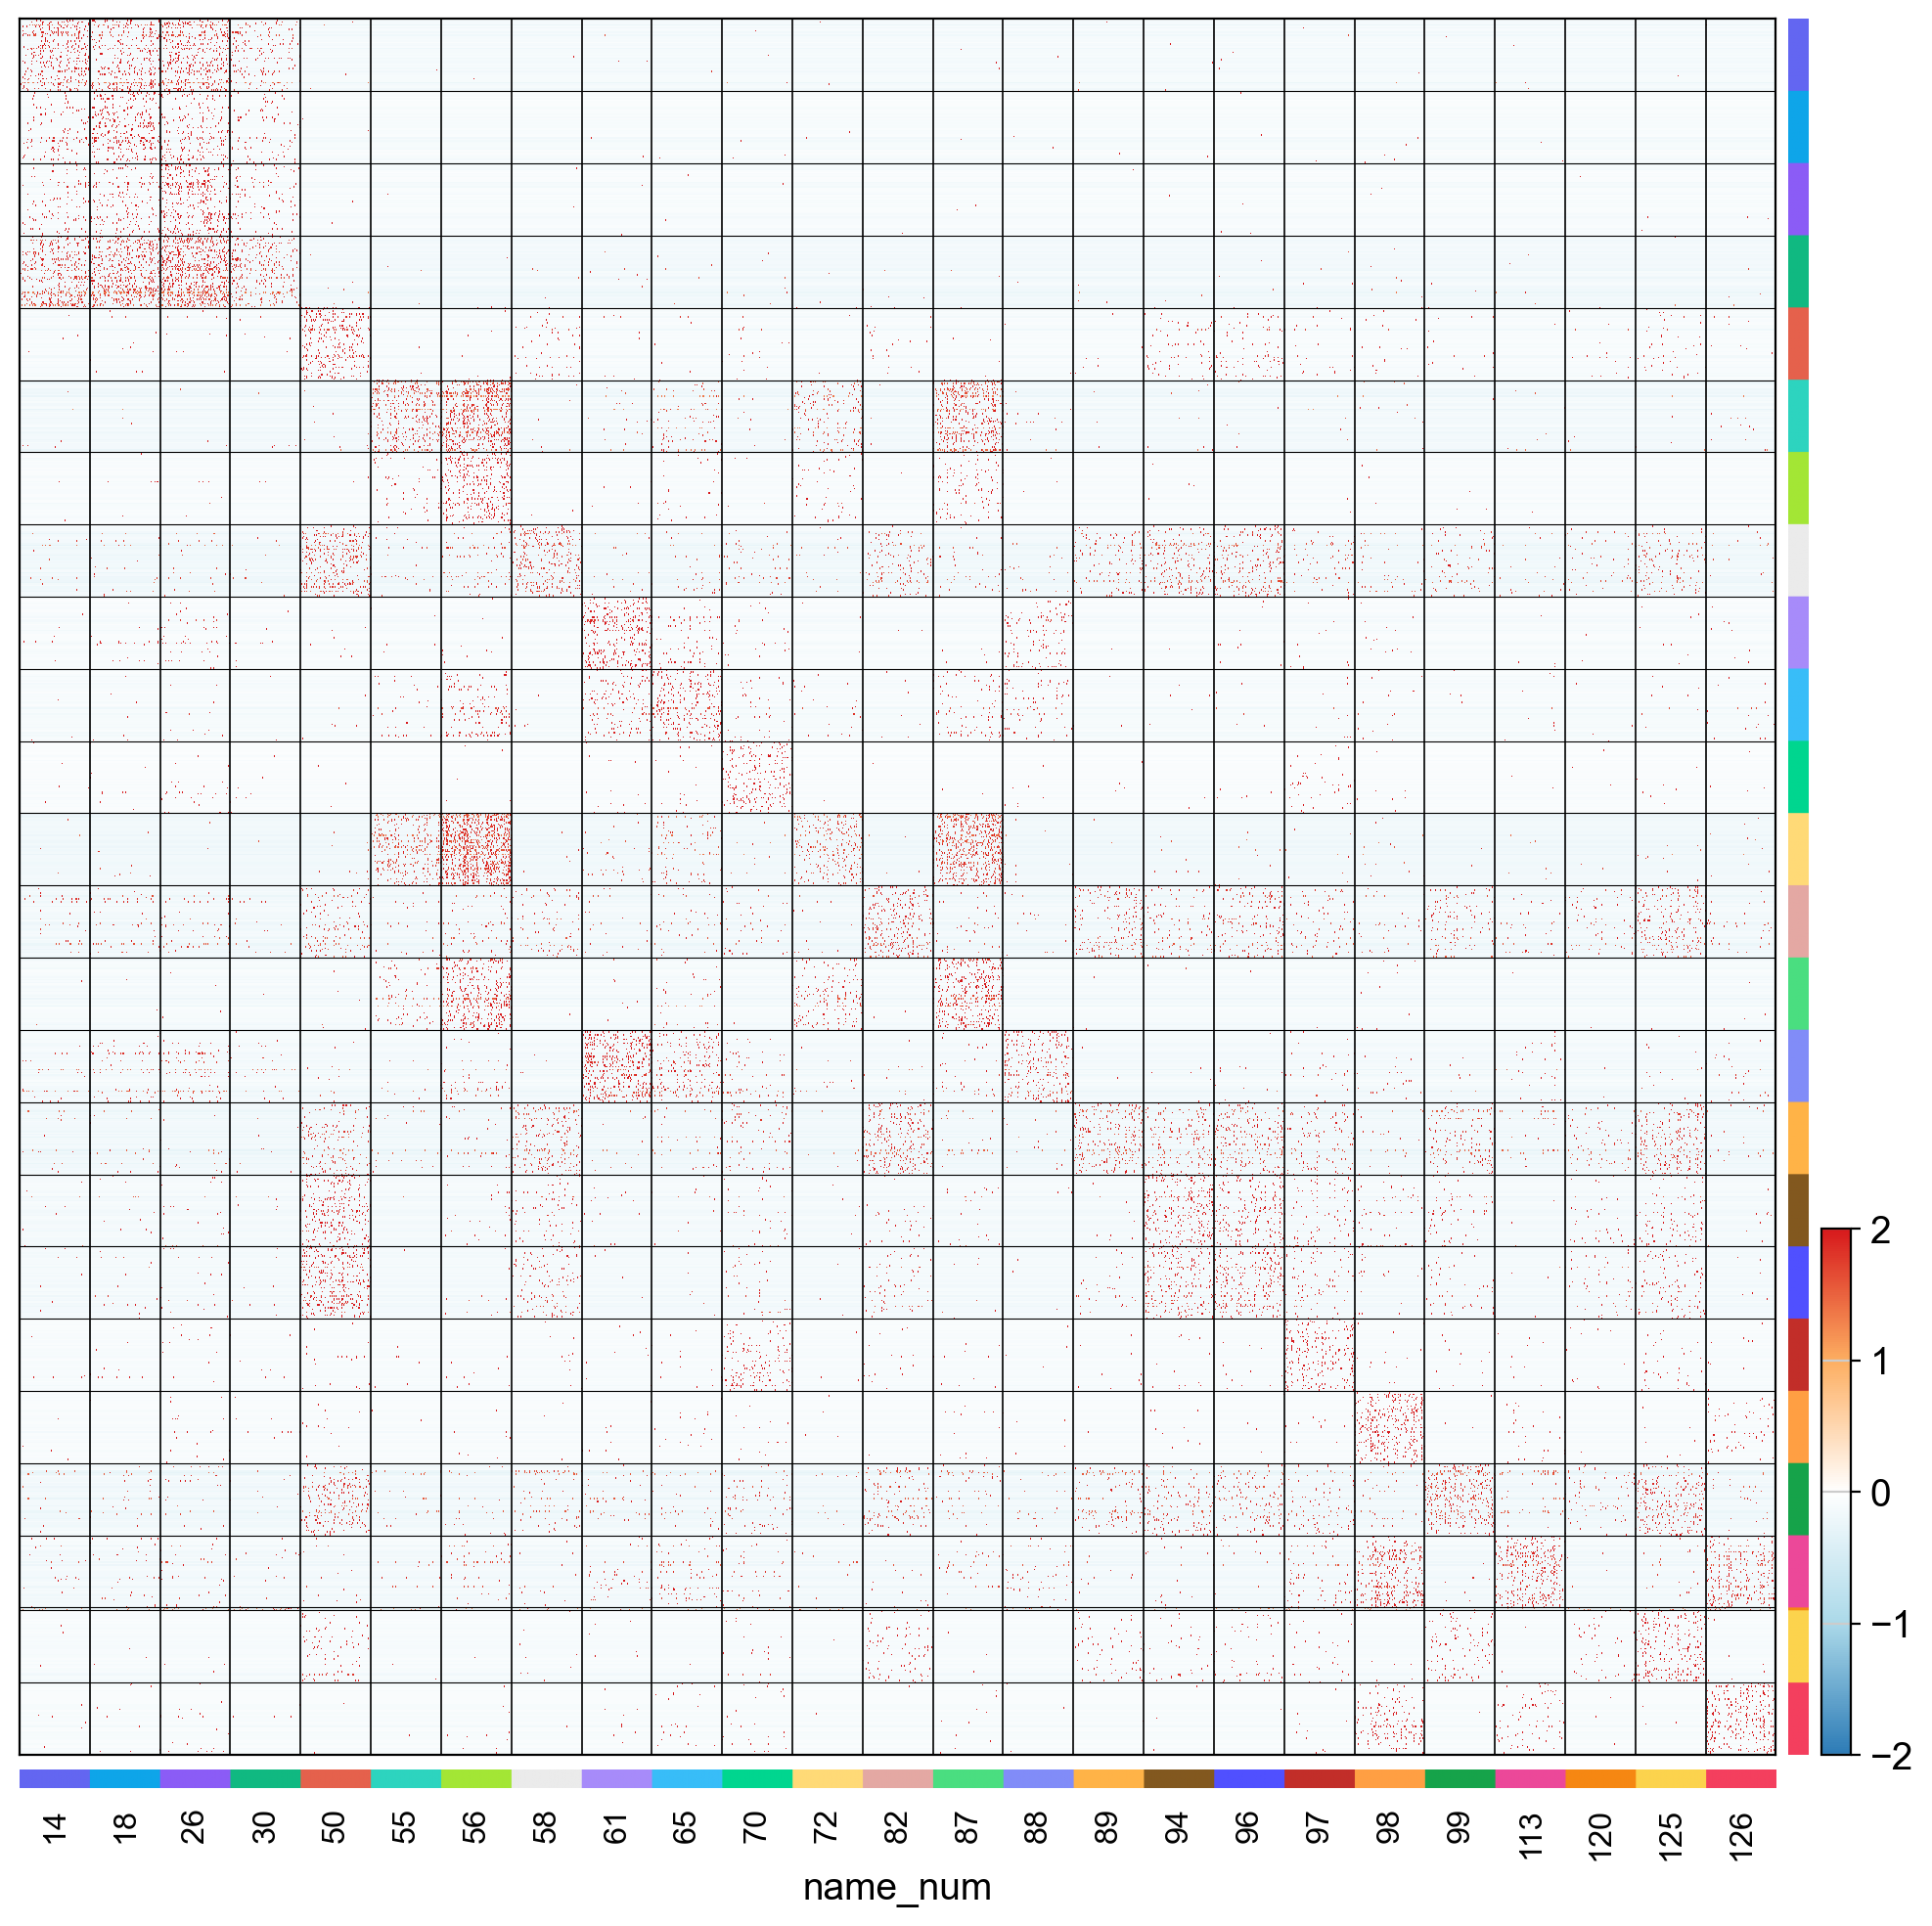

In [45]:
myht_save(plot_mat, sc_markers, 'name_num', fc=0.1, padj=0.05, pct1=0.05,
         pct2=0.05, figsize=(12,12), gene_size=6,#vmin=-1, vmax=1,
         topn=50, orderby='logfoldchanges', shift=0.5, genesymboe=None, show_gene_labels=False,
         save_path='./placeholder_output/raw_figure_output/Supp01/Stroma_round4_peak_ht.pdf', dpi=500)